### Imports & Warnings

In [1]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from train import iterate as train_iter
from evaluate import iterate as val_iter

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?.*?")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*?.*?")

### Dataset Functions

In [3]:
from torchvision import transforms
from torchvision.transforms import functional as TF
import random


def transform(data, mask):
    # Probability of applying flip transformations
    h_flip_prob = random.random()
    v_flip_prob = random.random()

    for sat in data:
        image, date = data[sat]

        # Transform to tensor
        image = torch.tensor(image)

        # Random horizontal flipping
        if h_flip_prob > 0.5:
            image = TF.hflip(image)

        # Random vertical flipping
        if v_flip_prob > 0.5:
            image = TF.vflip(image)

        # Random Brightness
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.5, 1.5)
            image = image * brightness_factor

        # Gaussian Blur
        if random.random() > 0.5:
            image = TF.gaussian_blur(image, [3, 3])

        data[sat] = (image, date)

    mask = torch.tensor(mask)
    # Random horizontal flipping
    if h_flip_prob > 0.5:
        mask = TF.hflip(mask)
    # Random vertical flipping
    if v_flip_prob > 0.5:
        mask = TF.vflip(mask)
    return data, mask


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [4]:
import os
import rasterio
import glob
import cv2
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from datetime import date
import pandas as pd

# torch
from torch.utils.data import Dataset

# Albumentation for augmentation
import albumentations as A

mon_to_int = {"jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6, "jul": 7, "aug": 8, "sep": 9, "oct": 10,
              "nov": 11, "dec": 12}


class UNET3d_Dataset(Dataset):
    def __init__(
            self,
            df,
            data_dir,
            satellite="S2",
            bands=['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'],
            img_size=(32, 32),
            mask_res=10,
            ignore_index=0,
            transform=True,
            test=False,
            preload=False,
            phase="train"
    ):
        super(UNET3d_Dataset, self).__init__()

        self.df = df
        self.plot_ids = set(df.PLOT_ID)
        self.satellite = satellite
        self.mask_res = mask_res
        self.bands = bands
        self.data_dir = data_dir
        self.transform = transform
        self.test = test
        self.ignore_index = ignore_index
        self.img_size = img_size
        self.resize = A.Resize(height=img_size[0], width=img_size[1])
        self.preload = preload
        self.phase = phase

        #  Preloading data
        if preload:
            UIDs = list(df.UNIQUE_ID)
            with Pool(32) as p:
                self.samples = list(tqdm(p.imap(self._read_sample, UIDs), total=len(UIDs), desc='Preloading Samples: '))
            data = {}
            for sample in self.samples: data.update(sample)
            self.samples = data

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        uid = int(self.df.iloc[idx]["UNIQUE_ID"])
        if self.preload:
            sample, mask = self.samples[uid]
        else:
            sample, mask = self._read_sample(uid)[uid]

        plot_mask = mask[0]

        # Remove plots that are not in this split
        unmatched_plots = set(np.unique(plot_mask)[1:]) - self.plot_ids
        for unmatched_plot in unmatched_plots:
            mask[:, plot_mask == unmatched_plot] = self.ignore_index

        # Transform data
        if self.phase == "train" and self.transform:
            sample, mask = transform(sample, mask)
        else:
            sample = torch.tensor(sample)
            mask = torch.tensor(mask)

        # change shape to CxTxHxW
        sample = sample.permute(1, 0, 2, 3)
        mask = {
            "crop_type": mask[1],
            "sowing_date": mask[2],
            "transplanting_date": mask[3],
            "harvesting_date": mask[4],
            "crop_yield": mask[5],
        }
        return uid, sample, mask

    def check_zero_percentage(self, image):
        all_pixels = np.prod(self.img_size)
        zero_pixels = len(image[image == 0])
        return zero_pixels / all_pixels

    def _read_masks(self, uid):
        path = f"{self.data_dir}/masks/{self.mask_res}m/{uid}.tif"
        with rasterio.open(path, 'r') as fp:
            mask = fp.read()
        # only make crop mask binary and change ignore_index
        mask[0][mask[0]==0]=-1
        mask[1] -= 1
        # Make Cropt type binary i.e. paddy vs non-paddy
        mask[1][mask[1] > 1] = 1
        mask[2] -= 1
        # mask[2][mask[2] == -1] = self.ignore_index
        mask[3] -= 1
        # mask[3][mask[3] == -1] = self.ignore_index
        mask[4] -= 1
        # mask[4][mask[4] == -1] = self.ignore_index
        mask[5][mask[5] == 0] = -1
        mask[mask < -1] = 0
        mask[mask < 0] = self.ignore_index
        return mask

    def _read_sample(self, uid):
        #  get metadata
        season, year = self.df[self.df.UNIQUE_ID == int(uid)].iloc[0][["STANDARD_SEASON", "YEAR"]].values
        start_date = date(int(year), mon_to_int[season.split("-")[0]], 1)
        size = self.img_size

        # get all files associated this UID
        path = f"{self.data_dir}/images/{self.satellite}/npy/{uid}/*.npz"
        files = glob.glob(path)

        mask = self._read_masks(uid).transpose(1, 2, 0)
        mask = self.resize(image=mask)["image"].transpose(2, 0, 1)

        # define empty sample
        sample = np.zeros((184, len(self.bands), *size))
        missing_count = 0
        for file in files:
            print(file)
            try:
                data, index, zero_percentage = self._read_data(file, start_date)
            except Exception as e:
                missing_count+=1
                print("\n", e,"\n")
            # only consider data_file if no of zeros is less than 25%
            if zero_percentage < 0.25:
                sample[index] = data

        print(uid, missing_count)
        return {uid: (sample, mask)}

    def _read_data(self, file, start_date):
        # Read File
        data_file = np.load(file)
        # Get index of file
        index = self._get_data_index(file, start_date)
        # find zero percentage
        zero_percentage = self.check_zero_percentage(data_file[self.bands[0]])
        # get channels data
        try:
            all_channels = [self.resize(image=data_file[band])["image"] for band in self.bands]
        except Exception as e:
            # print("file ",file,"error ",e)
            all_channels = [self.resize(image=data_file[band])["image"] for band in self.bands[:-1]]
            all_channels = all_channels + [np.zeros(self.img_size, dtype=np.float32)]
        data = np.stack(all_channels, axis=0)
        return data, index, zero_percentage

    def _get_data_index(self, file, start_date):
        if self.satellite == "S2":
            # for S2_2018 data
            if os.path.basename(file)[0]=="T": index_date = os.path.basename(file).split("_")[1][:8]
            else: index_date = os.path.basename(file).split("_")[0][:8]

        elif self.satellite == "S1":
            index_date = os.path.basename(file).split("_")[4][:8]
        else:
            index_date = os.path.basename(file).split("_")[2][:8]
        index_date = date(int(index_date[:4]), int(index_date[4:6]), int(index_date[6:]))
        index = (index_date - start_date).days
        return index


class SICKLE_Dataset(UNET3d_Dataset):
    def __init__(
            self,
            df,
            data_dir,
            satellites={"S2": {
                "bands": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'],
                "rgb_bands": [3, 2, 1],
                "mask_res": 10,
                "img_size": (32, 32),
            }},
            ignore_index=-999,
            transform=None,
            actual_season=False,
            phase="eval"
    ):
        self.df = df
        self.plot_ids = set(df.PLOT_ID)
        self.satellites = satellites
        self.data_dir = data_dir
        self.transform = transform
        self.ignore_index = ignore_index
        primary_sat = list(self.satellites.keys())[0]
        self.img_size = self.satellites[primary_sat]["img_size"]
        self.mask_res = self.satellites[primary_sat]["mask_res"]
        self.resize = A.Resize(height=self.img_size[0], width=self.img_size[1], interpolation=cv2.INTER_NEAREST)
        self.actual_season = actual_season
        self.phase = phase

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        uid = int(self.df.iloc[idx]["UNIQUE_ID"])
        data = {}
        for satellite, satellite_info in self.satellites.items():
            # update satellite info
            self.satellite = satellite
            self.bands = satellite_info["bands"]
            # read sample
            sample, dates = self._read_sample(uid)[uid]
            data[satellite] = (sample, dates)

        # read and prepare mask
        mask = self._read_masks(uid).transpose(1, 2, 0)
        mask = self.resize(image=mask)["image"].transpose(2, 0, 1)

        # Remove plots that are not in this split
        plot_mask = mask[0]
        unmatched_plots = set(np.unique(plot_mask)[1:]) - self.plot_ids
        for unmatched_plot in unmatched_plots:
            mask[:, plot_mask == unmatched_plot] = self.ignore_index
        #transform/augment data
        if self.phase == "train" and self.transform:
            data, mask = transform(data, mask)

        mask = {
            "plot_mask": mask[0],
            "crop_type": mask[1],
            "sowing_date": mask[2],
            "transplanting_date": mask[3],
            "harvesting_date": mask[4],
            "crop_yield": mask[5],
        }
        return data, mask

    def _read_sample(self, uid):
        #  get metadata
        season, year = self.df[self.df.UNIQUE_ID == int(uid)].iloc[0][["STANDARD_SEASON", "YEAR"]].values
        start_date = date(int(year), mon_to_int[season.split("-")[0]], 1)

        # get all files associated this UID
        path = f"{self.data_dir}/images/{self.satellite}/npy/{uid}/*.npz"
        files = glob.glob(path)

        # define empty sample and dates
        sample = []
        dates = []

        if self.actual_season:
            sowing_day, harvesting_day = self.df[self.df.UNIQUE_ID == int(uid)].iloc[0][
                ["SOWING_DAY", "HARVESTING_DAY"]].values
        else:
            sowing_day, harvesting_day = 0, 183
        # print(files)
        missing_count = 0
        for file in files:
            try:
                data, index, zero_percentage = self._read_data(file, start_date)
                if sowing_day <= index <= harvesting_day:
                # only consider data_file if no of zeros is less than 25%
                    if zero_percentage < 0.25:
                        if index not in dates:
                            dates.append(index)
                            sample.append(data)
            except Exception as e:
                missing_count+=1

        # correct order
        dates, sample = zip(*sorted(zip(dates, sample)))
        sample = np.stack(sample)
        dates = torch.tensor(dates)
        return {uid: (sample, dates)}

    def _get_data_index(self, file, start_date):
        index = UNET3d_Dataset._get_data_index(self, file, start_date)
        return index + 1

### Utils

In [5]:
import collections.abc
import re

import torch
from torch.nn import functional as F
from torch.utils import data

np_str_obj_array_pattern = re.compile(r"[SaUO]")


def pad_tensor(x, l, pad_value=0):
    padlen = l - x.shape[0]
    pad = [0 for _ in range(2 * len(x.shape[1:]))] + [0, padlen]
    return F.pad(x, pad=pad, value=pad_value)


def pad_collate(batch, pad_value=0):
    # modified default_collate from the official pytorch repo
    # https://github.com/pytorch/pytorch/blob/master/torch/utils/data/_utils/collate.py
    elem = batch[0]
    elem_type = type(elem)

    if isinstance(elem, torch.Tensor):
        out = None
        if len(elem.shape) > 0:
            sizes = [e.shape[0] for e in batch]
            m = max(sizes)
            if not all(s == m for s in sizes):
                # pad tensors which have a temporal dimension
                batch = [pad_tensor(e, m, pad_value=pad_value) for e in batch]
        if torch.utils.data.get_worker_info() is not None:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = elem.storage()._new_shared(numel)
            out = elem.new(storage)
        return torch.stack(batch, 0, out=out)
    elif (
        elem_type.__module__ == "numpy"
        and elem_type.__name__ != "str_"
        and elem_type.__name__ != "string_"
    ):
        if elem_type.__name__ == "ndarray" or elem_type.__name__ == "memmap":
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError("Format not managed : {}".format(elem.dtype))

            return pad_collate([torch.as_tensor(b) for b in batch])
        elif elem.shape == ():  # scalars
            return torch.as_tensor(batch)
    elif isinstance(elem, collections.abc.Mapping):
        return {key: pad_collate([d[key] for d in batch]) for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, "_fields"):  # namedtuple
        return elem_type(*(pad_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, collections.abc.Sequence):
        # check to make sure that the elements in batch have consistent size
        it = iter(batch)
        elem_size = len(next(it))
        if not all(len(elem) == elem_size for elem in it):
            raise RuntimeError("each element in list of batch should be of equal size")
        transposed = zip(*batch)
        return [pad_collate(samples) for samples in transposed]

    raise TypeError("Format not managed : {}".format(elem_type))

def get_ntrainparams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
import torch.nn as nn
import torch.nn.init as init

def weight_init(m):
    '''
    Initializes a model's parameters.
    Credits to: https://gist.github.com/jeasinema

    Usage:
        model = Model()
        model.apply(weight_init)
    '''
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=0, std=1)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=0, std=1)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=0, std=1)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        try:
            init.normal_(m.bias.data)
        except AttributeError:
            pass
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [7]:
from torchmetrics import F1Score, Accuracy, JaccardIndex, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError

import torch
import torch.nn as nn

class RMSELoss(nn.Module):
    def __init__(self, ignore_index=-999, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        self.ignore_index = ignore_index

    def forward(self,yhat,y, plot_mask=None):
        if plot_mask is not None:
            yhat, y = get_combined_yield(yhat, y, plot_mask)
        yhat = yhat.squeeze()
        yhat = yhat[y != self.ignore_index]
        y = y[y != self.ignore_index]
        loss = torch.sqrt(self.mse(yhat, y) + self.eps)
        return loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metrics = {
    "f1": F1Score(average="none", task='multiclass', num_classes=2, ignore_index=-999, threshold=0.5).to(device=device),
    "acc_cls": Accuracy(average="none", task='multiclass', num_classes=2, ignore_index=-999, threshold=0.5).to(device=device),
    "iou_cls": JaccardIndex(average="none", task="multiclass", num_classes=2, ignore_index=-999, threshold=0.5).to(device=device),
    "f1_macro": F1Score(average="macro", task='multiclass', num_classes=2, ignore_index=-999, threshold=0.5).to(device=device),
    "acc": Accuracy(task='multiclass', num_classes=2, ignore_index=-999, threshold=0.5).to(device=device),
    "iou": JaccardIndex(task="multiclass", num_classes=2, ignore_index=-999, threshold=0.5).to(device=device),
    "rmse" : RMSELoss(ignore_index =-999).to(device=device),
    "mae": torch.nn.L1Loss(),
    "mape": MeanAbsolutePercentageError().to(device=device),
}

def get_metrics(y_pred, y_true, pid_masks, ignore_index=-999, task="crop_type"):
    if task != "crop_type":
        return get_regression_metrics(y_pred, y_true,pid_masks, ignore_index, task)
    paddy_f1, non_paddy_f1 = metrics["f1"](y_pred, y_true)
    paddy_acc, non_paddy_acc = metrics["acc_cls"](y_pred, y_true)
    paddy_iou, non_paddy_iou = metrics["iou_cls"](y_pred, y_true)
    f1_macro = metrics["f1_macro"](y_pred, y_true)
    acc = metrics["acc"](y_pred, y_true)
    iou = metrics["iou"](y_pred, y_true)

    y_pred = torch.argmax(y_pred, dim=1)
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = y_pred[y_true != ignore_index]
    y_true = y_true[y_true != ignore_index]

    return f1_macro, acc, iou, paddy_f1, non_paddy_f1, paddy_acc, non_paddy_acc, paddy_iou, non_paddy_iou, (y_pred, y_true)

def get_regression_metrics(y_pred, y_true, pid_masks, ignore_index=-999, task=None):
    if task == "crop_yield":
        y_pred, y_true = get_combined_yield(y_pred, y_true, pid_masks)
        mape = metrics["mape"](y_pred, y_true)
    else:
        mape = MAPE(y_pred, y_true, ignore_index=-999)
    # rmse already handles ignore index
    rmse = metrics["rmse"](y_pred, y_true)
    # handle ignore index for others

    y_pred = y_pred.squeeze()
    y_pred = y_pred[y_true != -999]
    y_true = y_true[y_true != -999]
    mae = metrics["mae"](y_pred, y_true)

    return rmse, mae, mape

def get_combined_yield(y_pred, y_true, pid_masks):
    y_pred, y_true, pid_masks = y_pred.squeeze(), y_true.squeeze(), pid_masks.squeeze()
    y_pred_temp, y_true_temp = None, None

    # combine plot yield
    for i in range(pid_masks.size(0)):
        pids = torch.unique(pid_masks[i])
        for pid in pids:
            if pid != -999 and torch.sum(y_true[i,pid_masks[i]==pid]) > 0:
                if y_true_temp is None:
                    y_pred_temp = torch.sum(y_pred[i,pid_masks[i]==pid]).reshape(1)
                    y_true_temp = torch.sum(y_true[i,pid_masks[i]==pid]).reshape(1)
                else:
                    y_pred_temp = torch.cat((y_pred_temp,torch.sum(y_pred[i,pid_masks[i]==pid]).reshape(1)), dim=0)
                    y_true_temp = torch.cat((y_true_temp,torch.sum(y_true[i,pid_masks[i]==pid]).reshape(1)), dim=0)
    return y_pred_temp, y_true_temp

def MAPE(y_pred, y_true, ignore_index):
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    y_pred = y_pred[y_true != ignore_index]
    y_true = y_true[y_true != ignore_index]
    mae_metric = torch.nn.L1Loss(reduction="none")
    mae = mae_metric(y_pred, y_true)
    return torch.mean(mae / 183.)

### Model Functions

In [8]:
"""
U-TAE Implementation
Author: Vivien Sainte Fare Garnot (github/VSainteuf)
License: MIT
"""
import torch
import torch.nn as nn

from models.ltae import LTAE2d


class UTAE(nn.Module):
    def __init__(
        self,
        input_dim,
        encoder_widths=[64, 64, 64, 128],
        decoder_widths=[32, 32, 64, 128],
        out_conv=[32, 2],
        str_conv_k=4,
        str_conv_s=2,
        str_conv_p=1,
        agg_mode="att_group",
        encoder_norm="group",
        n_head=16,
        d_model=256,
        d_k=4,
        encoder=False,
        return_maps=False,
        pad_value=0,
        padding_mode="reflect",
    ):
        """
        U-TAE architecture for spatio-temporal encoding of satellite image time series.
        Args:
            input_dim (int): Number of channels in the input images.
            encoder_widths (List[int]): List giving the number of channels of the successive encoder_widths of the convolutional encoder.
            This argument also defines the number of encoder_widths (i.e. the number of downsampling steps +1)
            in the architecture.
            The number of channels are given from top to bottom, i.e. from the highest to the lowest resolution.
            decoder_widths (List[int], optional): Same as encoder_widths but for the decoder. The order in which the number of
            channels should be given is also from top to bottom. If this argument is not specified the decoder
            will have the same configuration as the encoder.
            out_conv (List[int]): Number of channels of the successive convolutions for the
            str_conv_k (int): Kernel size of the strided up and down convolutions.
            str_conv_s (int): Stride of the strided up and down convolutions.
            str_conv_p (int): Padding of the strided up and down convolutions.
            agg_mode (str): Aggregation mode for the skip connections. Can either be:
                - att_group (default) : Attention weighted temporal average, using the same
                channel grouping strategy as in the LTAE. The attention masks are bilinearly
                resampled to the resolution of the skipped feature maps.
                - att_mean : Attention weighted temporal average,
                 using the average attention scores across heads for each date.
                - mean : Temporal average excluding padded dates.
            encoder_norm (str): Type of normalisation layer to use in the encoding branch. Can either be:
                - group : GroupNorm (default)
                - batch : BatchNorm
                - instance : InstanceNorm
            n_head (int): Number of heads in LTAE.
            d_model (int): Parameter of LTAE
            d_k (int): Key-Query space dimension
            encoder (bool): If true, the feature maps instead of the class scores are returned (default False)
            return_maps (bool): If true, the feature maps instead of the class scores are returned (default False)
            pad_value (float): Value used by the dataloader for temporal padding.
            padding_mode (str): Spatial padding strategy for convolutional layers (passed to nn.Conv2d).
        """
        super(UTAE, self).__init__()
        self.n_stages = len(encoder_widths)
        self.return_maps = return_maps
        self.encoder_widths = encoder_widths
        self.decoder_widths = decoder_widths
        self.enc_dim = (
            decoder_widths[0] if decoder_widths is not None else encoder_widths[0]
        )
        self.stack_dim = (
            sum(decoder_widths) if decoder_widths is not None else sum(encoder_widths)
        )
        self.pad_value = pad_value
        self.encoder = encoder
        if encoder:
            self.return_maps = True

        if decoder_widths is not None:
            assert len(encoder_widths) == len(decoder_widths)
            assert encoder_widths[-1] == decoder_widths[-1]
        else:
            decoder_widths = encoder_widths

        self.in_conv = ConvBlock(
            nkernels=[input_dim] + [encoder_widths[0], encoder_widths[0]],
            pad_value=pad_value,
            norm=encoder_norm,
            padding_mode=padding_mode,
        )
        self.down_blocks = nn.ModuleList(
            DownConvBlock(
                d_in=encoder_widths[i],
                d_out=encoder_widths[i + 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                pad_value=pad_value,
                norm=encoder_norm,
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1)
        )
        self.up_blocks = nn.ModuleList(
            UpConvBlock(
                d_in=decoder_widths[i],
                d_out=decoder_widths[i - 1],
                d_skip=encoder_widths[i - 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                norm="batch",
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1, 0, -1)
        )
        self.temporal_encoder = LTAE2d(
            in_channels=encoder_widths[-1],
            d_model=d_model,
            n_head=n_head,
            mlp=[d_model, encoder_widths[-1]],
            return_att=True,
            d_k=d_k,
        )
        self.temporal_aggregator = Temporal_Aggregator(mode=agg_mode)
        self.out_conv = ConvBlock(nkernels=[decoder_widths[0]] + out_conv, padding_mode=padding_mode)

    def forward(self, input, batch_positions=None, return_att=False):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask
        out = self.in_conv.smart_forward(input)
        feature_maps = [out]
        # SPATIAL ENCODER
        # print("SPATIAL ENCODER")
        for i in range(self.n_stages - 1):
            out = self.down_blocks[i].smart_forward(feature_maps[-1])
            feature_maps.append(out)
        # TEMPORAL ENCODER
        # print("TEMPORAL ENCODER")
        # print(feature_maps[-1].shape)
        out, att = self.temporal_encoder(
            feature_maps[-1], batch_positions=batch_positions, pad_mask=pad_mask
        )
        # SPATIAL DECODER
        # print("SPATIAL ENCODER")
        if self.return_maps:
            maps = [out]
        for i in range(self.n_stages - 1):
            skip = self.temporal_aggregator(
                feature_maps[-(i + 2)], pad_mask=pad_mask, attn_mask=att
            )
            out = self.up_blocks[i](out, skip)
            if self.return_maps:
                maps.append(out)

        if self.encoder:
            return out, maps
        else:
            out = self.out_conv(out)
            if return_att:
                return out, att
            if self.return_maps:
                return out, maps
            else:
                return out


class TemporallySharedBlock(nn.Module):
    """
    Helper module for convolutional encoding blocks that are shared across a sequence.
    This module adds the self.smart_forward() method the the block.
    smart_forward will combine the batch and temporal dimension of an input tensor
    if it is 5-D and apply the shared convolutions to all the (batch x temp) positions.
    """

    def __init__(self, pad_value=None):
        super(TemporallySharedBlock, self).__init__()
        self.out_shape = None
        self.pad_value = pad_value

    def smart_forward(self, input):
        if len(input.shape) == 4:
            return self.forward(input)
        else:
            b, t, c, h, w = input.shape

            if self.pad_value is not None:
                dummy = torch.zeros(input.shape, device=input.device).float()
                self.out_shape = self.forward(dummy.view(b * t, c, h, w)).shape

            out = input.view(b * t, c, h, w)
            if self.pad_value is not None:
                pad_mask = (out == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
                if pad_mask.any():
                    temp = (
                        torch.ones(
                            self.out_shape, device=input.device, requires_grad=False
                        )
                        * self.pad_value
                    )
                    temp[~pad_mask] = self.forward(out[~pad_mask])
                    out = temp
                else:
                    out = self.forward(out)
            else:
                out = self.forward(out)
            _, c, h, w = out.shape
            out = out.view(b, t, c, h, w)
            return out


class ConvLayer(nn.Module):
    def __init__(
        self,
        nkernels,
        norm="batch",
        k=3,
        s=1,
        p=1,
        n_groups=4,
        last_relu=True,
        padding_mode="reflect",
    ):
        super(ConvLayer, self).__init__()
        layers = []
        if norm == "batch":
            nl = nn.BatchNorm2d
        elif norm == "instance":
            nl = nn.InstanceNorm2d
        elif norm == "group":
            nl = lambda num_feats: nn.GroupNorm(
                num_channels=num_feats,
                num_groups=n_groups,
            )
        else:
            nl = None
        for i in range(len(nkernels) - 1):
            layers.append(
                nn.Conv2d(
                    in_channels=nkernels[i],
                    out_channels=nkernels[i + 1],
                    kernel_size=k,
                    padding=p,
                    stride=s,
                    padding_mode=padding_mode,
                )
            )
            if nl is not None:
                layers.append(nl(nkernels[i + 1]))

            if last_relu:
                layers.append(nn.ReLU())
            elif i < len(nkernels) - 2:
                layers.append(nn.ReLU())
        self.conv = nn.Sequential(*layers)

    def forward(self, input):
        return self.conv(input)


class ConvBlock(TemporallySharedBlock):
    def __init__(
        self,
        nkernels,
        pad_value=None,
        norm="batch",
        last_relu=True,
        padding_mode="reflect",
    ):
        super(ConvBlock, self).__init__(pad_value=pad_value)
        self.conv = ConvLayer(
            nkernels=nkernels,
            norm=norm,
            last_relu=last_relu,
            padding_mode=padding_mode,
        )

    def forward(self, input):
        return self.conv(input)


class DownConvBlock(TemporallySharedBlock):
    def __init__(
        self,
        d_in,
        d_out,
        k,
        s,
        p,
        pad_value=None,
        norm="batch",
        padding_mode="reflect",
    ):
        super(DownConvBlock, self).__init__(pad_value=pad_value)
        self.down = ConvLayer(
            nkernels=[d_in, d_in],
            norm=norm,
            k=k,
            s=s,
            p=p,
            padding_mode=padding_mode,
        )
        self.conv1 = ConvLayer(
            nkernels=[d_in, d_out],
            norm=norm,
            padding_mode=padding_mode,
        )
        self.conv2 = ConvLayer(
            nkernels=[d_out, d_out],
            norm=norm,
            padding_mode=padding_mode,
        )

    def forward(self, input):
        out = self.down(input)
        out = self.conv1(out)
        out = out + self.conv2(out)
        return out


class UpConvBlock(nn.Module):
    def __init__(
        self, d_in, d_out, k, s, p, norm="batch", d_skip=None, padding_mode="reflect"
    ):
        super(UpConvBlock, self).__init__()
        d = d_out if d_skip is None else d_skip
        self.skip_conv = nn.Sequential(
            nn.Conv2d(in_channels=d, out_channels=d, kernel_size=1),
            nn.BatchNorm2d(d),
            nn.ReLU(),
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=d_in, out_channels=d_out, kernel_size=k, stride=s, padding=p
            ),
            nn.BatchNorm2d(d_out),
            nn.ReLU(),
        )
        self.conv1 = ConvLayer(
            nkernels=[d_out + d, d_out], norm=norm, padding_mode=padding_mode
        )
        self.conv2 = ConvLayer(
            nkernels=[d_out, d_out], norm=norm, padding_mode=padding_mode
        )

    def forward(self, input, skip):
        out = self.up(input)
        out = torch.cat([out, self.skip_conv(skip)], dim=1)
        out = self.conv1(out)
        out = out + self.conv2(out)
        return out


class Temporal_Aggregator(nn.Module):
    def __init__(self, mode="mean"):
        super(Temporal_Aggregator, self).__init__()
        self.mode = mode

    def forward(self, x, pad_mask=None, attn_mask=None):
        if pad_mask is not None and pad_mask.any():
            if self.mode == "att_group":
                n_heads, b, t, h, w = attn_mask.shape
                attn = attn_mask.view(n_heads * b, t, h, w)

                if x.shape[-2] > w:
                    attn = nn.Upsample(
                        size=x.shape[-2:], mode="bilinear", align_corners=False
                    )(attn)
                else:
                    attn = nn.AvgPool2d(kernel_size=w // x.shape[-2])(attn)

                attn = attn.view(n_heads, b, t, *x.shape[-2:])
                attn = attn * (~pad_mask).float()[None, :, :, None, None]

                out = torch.stack(x.chunk(n_heads, dim=2))  # hxBxTxC/hxHxW
                out = attn[:, :, :, None, :, :] * out
                out = out.sum(dim=2)  # sum on temporal dim -> hxBxC/hxHxW
                out = torch.cat([group for group in out], dim=1)  # -> BxCxHxW
                return out
            elif self.mode == "att_mean":
                attn = attn_mask.mean(dim=0)  # average over heads -> BxTxHxW
                attn = nn.Upsample(
                    size=x.shape[-2:], mode="bilinear", align_corners=False
                )(attn)
                attn = attn * (~pad_mask).float()[:, :, None, None]
                out = (x * attn[:, :, None, :, :]).sum(dim=1)
                return out
            elif self.mode == "mean":
                out = x * (~pad_mask).float()[:, :, None, None, None]
                out = out.sum(dim=1) / (~pad_mask).sum(dim=1)[:, None, None, None]
                return out
        else:
            if self.mode == "att_group":
                n_heads, b, t, h, w = attn_mask.shape
                attn = attn_mask.view(n_heads * b, t, h, w)
                if x.shape[-2] > w:
                    attn = nn.Upsample(
                        size=x.shape[-2:], mode="bilinear", align_corners=False
                    )(attn)
                else:
                    attn = nn.AvgPool2d(kernel_size=w // x.shape[-2])(attn)
                attn = attn.view(n_heads, b, t, *x.shape[-2:])
                out = torch.stack(x.chunk(n_heads, dim=2))  # hxBxTxC/hxHxW
                out = attn[:, :, :, None, :, :] * out
                out = out.sum(dim=2)  # sum on temporal dim -> hxBxC/hxHxW
                out = torch.cat([group for group in out], dim=1)  # -> BxCxHxW
                return out
            elif self.mode == "att_mean":
                attn = attn_mask.mean(dim=0)  # average over heads -> BxTxHxW
                attn = nn.Upsample(
                    size=x.shape[-2:], mode="bilinear", align_corners=False
                )(attn)
                out = (x * attn[:, :, None, :, :]).sum(dim=1)
                return out
            elif self.mode == "mean":
                return x.mean(dim=1)


class RecUNet(nn.Module):
    """Recurrent U-Net architecture. Similar to the U-TAE architecture but
    the L-TAE is replaced by a recurrent network
    and temporal averages are computed for the skip connections."""

    def __init__(
        self,
        input_dim,
        encoder_widths=[64, 64, 64, 128],
        decoder_widths=[32, 32, 64, 128],
        out_conv=[32, 20],
        str_conv_k=4,
        str_conv_s=2,
        str_conv_p=1,
        temporal="lstm",
        input_size=128,
        encoder_norm="group",
        hidden_dim=128,
        encoder=False,
        padding_mode="reflect",
        pad_value=0,
    ):
        super(RecUNet, self).__init__()
        self.n_stages = len(encoder_widths)
        self.temporal = temporal
        self.encoder_widths = encoder_widths
        self.decoder_widths = decoder_widths
        self.enc_dim = (
            decoder_widths[0] if decoder_widths is not None else encoder_widths[0]
        )
        self.stack_dim = (
            sum(decoder_widths) if decoder_widths is not None else sum(encoder_widths)
        )
        self.pad_value = pad_value

        self.encoder = encoder
        if encoder:
            self.return_maps = True
        else:
            self.return_maps = False

        if decoder_widths is not None:
            assert len(encoder_widths) == len(decoder_widths)
            assert encoder_widths[-1] == decoder_widths[-1]
        else:
            decoder_widths = encoder_widths

        self.in_conv = ConvBlock(
            nkernels=[input_dim] + [encoder_widths[0], encoder_widths[0]],
            pad_value=pad_value,
            norm=encoder_norm,
        )

        self.down_blocks = nn.ModuleList(
            DownConvBlock(
                d_in=encoder_widths[i],
                d_out=encoder_widths[i + 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                pad_value=pad_value,
                norm=encoder_norm,
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1)
        )
        self.up_blocks = nn.ModuleList(
            UpConvBlock(
                d_in=decoder_widths[i],
                d_out=decoder_widths[i - 1],
                d_skip=encoder_widths[i - 1],
                k=str_conv_k,
                s=str_conv_s,
                p=str_conv_p,
                norm=encoder_norm,
                padding_mode=padding_mode,
            )
            for i in range(self.n_stages - 1, 0, -1)
        )
        self.temporal_aggregator = Temporal_Aggregator(mode="mean")

        if temporal == "mean":
            self.temporal_encoder = Temporal_Aggregator(mode="mean")
        elif temporal == "lstm":
            size = int(input_size / str_conv_s ** (self.n_stages - 1))
            self.temporal_encoder = ConvLSTM(
                input_dim=encoder_widths[-1],
                input_size=(size, size),
                hidden_dim=hidden_dim,
                kernel_size=(3, 3),
            )
            self.out_convlstm = nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=encoder_widths[-1],
                kernel_size=3,
                padding=1,
            )
        elif temporal == "blstm":
            size = int(input_size / str_conv_s ** (self.n_stages - 1))
            self.temporal_encoder = BConvLSTM(
                input_dim=encoder_widths[-1],
                input_size=(size, size),
                hidden_dim=hidden_dim,
                kernel_size=(3, 3),
            )
            self.out_convlstm = nn.Conv2d(
                in_channels=2 * hidden_dim,
                out_channels=encoder_widths[-1],
                kernel_size=3,
                padding=1,
            )
        elif temporal == "mono":
            self.temporal_encoder = None
        self.out_conv = ConvBlock(nkernels=[decoder_widths[0]] + out_conv, padding_mode=padding_mode)

    def forward(self, input, batch_positions=None):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask

        out = self.in_conv.smart_forward(input)

        feature_maps = [out]
        # ENCODER
        for i in range(self.n_stages - 1):
            out = self.down_blocks[i].smart_forward(feature_maps[-1])
            feature_maps.append(out)

        # Temporal encoder
        if self.temporal == "mean":
            out = self.temporal_encoder(feature_maps[-1], pad_mask=pad_mask)
        elif self.temporal == "lstm":
            _, out = self.temporal_encoder(feature_maps[-1], pad_mask=pad_mask)
            out = out[0][1]  # take last cell state as embedding
            out = self.out_convlstm(out)
        elif self.temporal == "blstm":
            out = self.temporal_encoder(feature_maps[-1], pad_mask=pad_mask)
            out = self.out_convlstm(out)
        elif self.temporal == "mono":
            out = feature_maps[-1]

        if self.return_maps:
            maps = [out]
        for i in range(self.n_stages - 1):
            if self.temporal != "mono":
                skip = self.temporal_aggregator(
                    feature_maps[-(i + 2)], pad_mask=pad_mask
                )
            else:
                skip = feature_maps[-(i + 2)]
            out = self.up_blocks[i](out, skip)
            if self.return_maps:
                maps.append(out)

        if self.encoder:
            return out, maps
        else:
            out = self.out_conv(out)
            if self.return_maps:
                return out, maps
            else:
                return out


In [9]:
"""
Taken from https://github.com/TUM-LMF/MTLCC-pytorch/blob/master/src/models/convlstm/convlstm.py
authors: TUM-LMF
"""
import torch.nn as nn
from torch.autograd import Variable
import torch


class ConvLSTMCell(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_size: (int, int)
            Height and width of input tensor as (height, width).
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.height, self.width = input_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat(
            [input_tensor, h_cur], dim=1
        )  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, device):
        return (
            Variable(
                torch.zeros(batch_size, self.hidden_dim, self.height, self.width)
            ).to(device),
            Variable(
                torch.zeros(batch_size, self.hidden_dim, self.height, self.width)
            ).to(device),
        )


class ConvLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        input_dim,
        hidden_dim,
        kernel_size,
        num_layers=1,
        batch_first=True,
        bias=True,
        return_all_layers=False,
    ):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.height, self.width = input_size

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(
                ConvLSTMCell(
                    input_size=(self.height, self.width),
                    input_dim=cur_input_dim,
                    hidden_dim=self.hidden_dim[i],
                    kernel_size=self.kernel_size[i],
                    bias=self.bias,
                )
            )

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None, pad_mask=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        pad_maks (b , t)
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            hidden_state = self._init_hidden(
                batch_size=input_tensor.size(0), device=input_tensor.device
            )

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c]
                )
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            if pad_mask is not None:
                last_positions = (~pad_mask).sum(dim=1) - 1
                layer_output = layer_output[:, last_positions, :, :, :]

            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, device):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, device))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (
            isinstance(kernel_size, tuple)
            or (
                isinstance(kernel_size, list)
                and all([isinstance(elem, tuple) for elem in kernel_size])
            )
        ):
            raise ValueError("`kernel_size` must be tuple or list of tuples")

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvLSTM_Seg(nn.Module):
    def __init__(
        self, num_classes, input_size, input_dim, hidden_dim, kernel_size, pad_value=0
    ):
        super(ConvLSTM_Seg, self).__init__()
        self.convlstm_encoder = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.classification_layer = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=num_classes,
            kernel_size=kernel_size,
            padding=1,
        )
        self.pad_value = pad_value

    def forward(self, input, batch_positions=None):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask
        pad_mask = pad_mask if pad_mask.any() else None
        _, states = self.convlstm_encoder(input, pad_mask=pad_mask)
        out = states[0][1]  # take last cell state as embedding
        out = self.classification_layer(out)

        return out


class BConvLSTM_Seg(nn.Module):
    def __init__(
        self, num_classes, input_size, input_dim, hidden_dim, kernel_size, pad_value=0
    ):
        super(BConvLSTM_Seg, self).__init__()
        self.convlstm_forward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.convlstm_backward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.classification_layer = nn.Conv2d(
            in_channels=2 * hidden_dim,
            out_channels=num_classes,
            kernel_size=kernel_size,
            padding=1,
        )
        self.pad_value = pad_value

    def forward(self, input, batch_posistions=None):
        pad_mask = (
            (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        )  # BxT pad mask
        pad_mask = pad_mask if pad_mask.any() else None

        # FORWARD
        _, forward_states = self.convlstm_forward(input, pad_mask=pad_mask)
        out = forward_states[0][1]  # take last cell state as embedding

        # BACKWARD
        x_reverse = torch.flip(input, dims=[1])
        if pad_mask is not None:
            pmr = torch.flip(pad_mask.float(), dims=[1]).bool()
            x_reverse = torch.masked_fill(x_reverse, pmr[:, :, None, None, None], 0)
            # Fill leading padded positions with 0s
        _, backward_states = self.convlstm_backward(x_reverse)

        out = torch.cat([out, backward_states[0][1]], dim=1)
        out = self.classification_layer(out)
        return out


class BConvLSTM(nn.Module):
    def __init__(self, input_size, input_dim, hidden_dim, kernel_size):
        super(BConvLSTM, self).__init__()
        self.convlstm_forward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )
        self.convlstm_backward = ConvLSTM(
            input_dim=input_dim,
            input_size=input_size,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size,
            return_all_layers=False,
        )

    def forward(self, input, pad_mask=None):
        # FORWARD
        _, forward_states = self.convlstm_forward(input, pad_mask=pad_mask)
        out = forward_states[0][1]  # take last cell state as embedding

        # BACKWARD
        x_reverse = torch.flip(input, dims=[1])
        if pad_mask is not None:
            pmr = torch.flip(pad_mask.float(), dims=[1]).bool()
            x_reverse = torch.masked_fill(x_reverse, pmr[:, :, None, None, None], 0)
            # Fill leading padded positions with 0s
        _, backward_states = self.convlstm_backward(x_reverse)

        out = torch.cat([out, backward_states[0][1]], dim=1)
        return out


In [10]:
import torch.nn as nn
import torch


class Build_model(nn.Module):
    def __init__(self, CFG):
        super(Build_model, self).__init__()
        self.CFG = CFG
        self.sat = list(CFG.satellites.keys())[0]
        self.model = self.get_model(self.sat)

    def forward(self, data):
        (images, dates) = data[self.sat]
        y_pred = self.model(images, batch_positions=dates)
        return y_pred

    def get_model(self,sat):
        config = self.CFG
        input_dim = len(config.satellites[sat]["bands"])
        if config.model == "utae":
            model = UTAE(
                input_dim=input_dim,
                encoder_widths=config.encoder_widths,
                decoder_widths=config.decoder_widths,
                out_conv=config.out_conv,
                str_conv_k=config.str_conv_k,
                str_conv_s=config.str_conv_s,
                str_conv_p=config.str_conv_p,
                agg_mode=config.agg_mode,
                encoder_norm=config.encoder_norm,
                n_head=config.n_head,
                d_model=config.d_model,
                d_k=config.d_k,
                encoder=False,
                return_maps=False,
                pad_value=config.pad_value,
                padding_mode=config.padding_mode,
            )
        elif config.model == "convlstm":
            model = ConvLSTM_Seg(
                num_classes=config.out_conv[-1],
                input_size=config.img_size,
                input_dim=input_dim,
                kernel_size=(3, 3),
                hidden_dim=160,
            )
        else:
            raise NotImplementedError
        return model


class Fusion_model(Build_model):
    def __init__(self, CFG):
        super(Fusion_model, self).__init__(CFG)
        self.CFG = CFG
        self.models = nn.ModuleDict()
        for satellite in CFG.satellites.keys():
            model = self.get_model(sat=satellite)
            self.models[satellite] = model
        self.conv_final = nn.Conv2d(len(self.CFG.satellites.keys()) * self.CFG.out_conv[-1], CFG.num_classes,kernel_size=3, stride=1, padding=1)

    def forward(self, data):
        y_preds = {}
        for satellite in self.CFG.satellites.keys():
            (images, dates) = data[satellite]
            model = self.models[satellite]
            y_preds[satellite] = model(images, batch_positions=dates)
        y_pred = torch.cat(list(y_preds.values()), dim=1)
        y_pred = self.conv_final(y_pred)
        return y_pred

### Dataset

In [11]:
# ### Collate function ###
PAD_VALUE = 0  # global pad value

def pad_collate_fn(batch):
    return pad_collate(batch, pad_value=PAD_VALUE)


# ### CONFIGURATION ###
DATA_ROOT    = Path(r"./sickle-002_contents")
WEIGHTS_ROOT = Path(r"./weights-001\runs\wacv_2024")

TASK        = "crop_type"
SATELLITES  = ["S1"]
MODEL_NAME  = "utae"

BATCH_SIZE   = 16
NUM_WORKERS  = 0      # ← set to zero for Jupyter
LR           = 1e-3
EPOCHS       = 10
SEED         = 42
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IGNORE_INDEX = -999

RUN_DIR  = WEIGHTS_ROOT / TASK / f"[{','.join(SATELLITES)}]_{MODEL_NAME}"
BEST_DIR = RUN_DIR

SAT_METADATA = {
    "S1": {"bands": ['VV','VH'], "rgb_bands":[0,1,0], "mask_res":10, "img_size":(32,32)},
    "S2": {"bands": ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12'], "rgb_bands":[3,2,1], "mask_res":10, "img_size":(32,32)},
    "L8": {"bands": ["SR_B1","SR_B2","SR_B3","SR_B4","SR_B5","SR_B6","SR_B7","ST_B10"], "rgb_bands":[3,2,1], "mask_res":10, "img_size":(32,32)},
}
REQUIRED_SAT_DATA = {s: SAT_METADATA[s] for s in SATELLITES}

In [12]:
# ### Utility Functions ###
def set_seed(seed:int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"> Random seed fixed to {seed}")

def get_data_loaders():
    df = pd.read_csv(DATA_ROOT / "sickle_dataset_tabular.csv")
    if TASK != "crop_type":
        df = df[df.YIELD>0].reset_index(drop=True)
    splits = {sp: df[df.SPLIT==sp].reset_index(drop=True) for sp in ("train","val","test")}
    ds_args = dict(
        data_dir=str(DATA_ROOT),
        satellites=REQUIRED_SAT_DATA,
        ignore_index=IGNORE_INDEX,
        transform=(TASK=="crop_type"),
        actual_season=False
    )
    ds_train = SICKLE_Dataset(df=splits["train"], phase="train", **ds_args)
    ds_val   = SICKLE_Dataset(df=splits["val"],   phase="val",   **ds_args)
    ds_test  = SICKLE_Dataset(df=splits["test"],  phase="test",  **ds_args)

    loader_args = dict(
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        collate_fn=pad_collate_fn,
        shuffle=True
    )
    train_loader = DataLoader(ds_train, **loader_args)
    loader_args["shuffle"] = False
    val_loader   = DataLoader(ds_val,   **loader_args)
    test_loader  = DataLoader(ds_test,  **loader_args)

    print(f"> Data sizes — train: {len(ds_train)}, val: {len(ds_val)}, test: {len(ds_test)}")
    return train_loader, val_loader, test_loader

def build_model_and_cfg():
    class CFG:
        model           = MODEL_NAME
        encoder_widths  = [64,128]
        decoder_widths  = [32,128]
        out_conv        = [32,16]
        str_conv_k      = 4
        str_conv_s      = 2
        str_conv_p      = 1
        agg_mode        = 'att_group'
        encoder_norm    = 'group'
        n_head          = 16
        d_model         = 256
        d_k             = 4
        padding_mode    = 'reflect'

        device          = DEVICE
        satellites      = REQUIRED_SAT_DATA
        task            = TASK
        epochs          = EPOCHS
        lr              = LR
        num_workers     = NUM_WORKERS
        batch_size      = BATCH_SIZE
        ignore_index    = IGNORE_INDEX
        pad_value       = PAD_VALUE
        actual_season   = False
        use_augmentation= (TASK=="crop_type")
        num_classes     = 2 if TASK=="crop_type" else 1

        seed            = SEED
        primary_sat     = list(REQUIRED_SAT_DATA.keys())[0]
        img_size        = REQUIRED_SAT_DATA[primary_sat]["img_size"]

    cfg   = CFG()
    model = Fusion_model(cfg).to(DEVICE)
    return model, cfg



### UTAE

In [13]:
# ### Run ###
set_seed(SEED)
train_loader, val_loader, test_loader = get_data_loaders()
model, cfg = build_model_and_cfg()
model.apply(weight_init)
print("> # params:", get_ntrainparams(model))

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX).to(DEVICE) if TASK=="crop_type" else RMSELoss(ignore_index=IGNORE_INDEX).to(DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# — Validation Only —
ckpt = torch.load(BEST_DIR/"checkpoint_best.pth.tar", map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()
val_loss, val_metrics, _ = val_iter(
    model, val_loader, criterion, optimizer,
    mode="val", device=DEVICE, task=TASK,
    log=True, CFG=cfg
)
print(f"\nValidation ({TASK}) →", val_metrics)

> Random seed fixed to 42
> Data sizes — train: 1937, val: 227, test: 206
> # params: 1060738


Val_Crop_Type: 100%|██████████| 15/15 [00:57<00:00,  3.80s/it, Loss=1.6254, gpu_mem=0.66 GB]


Validation (crop_type) → (tensor(0.6753, device='cuda:0'), tensor(0.7109, device='cuda:0'), tensor(0.5198, device='cuda:0'), tensor(0.5678, device='cuda:0'), tensor(0.7827, device='cuda:0'), tensor(0.7997, device='cuda:0'), tensor(0.6832, device='cuda:0'), tensor(0.3965, device='cuda:0'), tensor(0.6430, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))



Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.44      0.80      0.57      2342
       Paddy       0.92      0.68      0.78      7518

    accuracy                           0.71      9860
   macro avg       0.68      0.74      0.68      9860
weighted avg       0.80      0.71      0.73      9860



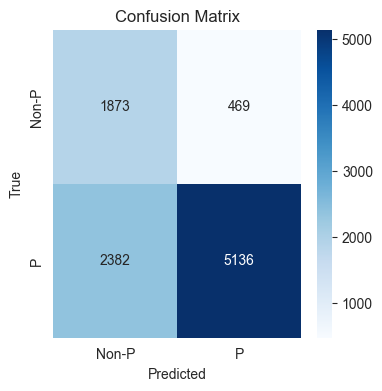

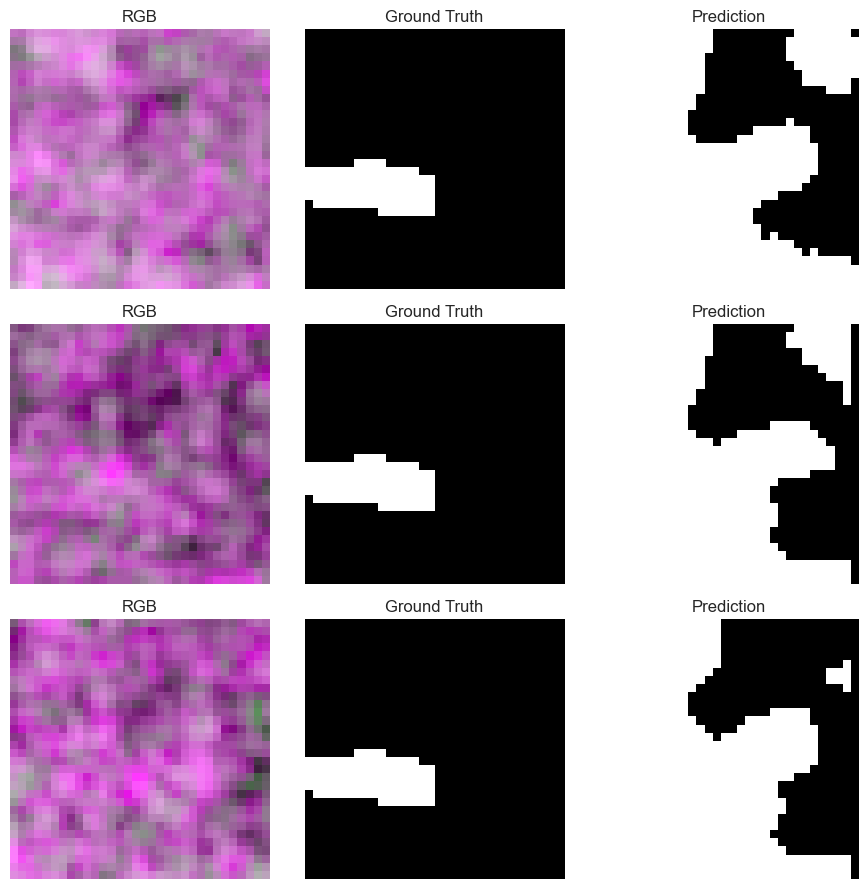

In [14]:
# ### Extra Metrics & Visualization ###

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# helper to move everything to device
def to_device(batch, device):
    if isinstance(batch, torch.Tensor):
        return batch.to(device)
    if isinstance(batch, dict):
        return {k: to_device(v, device) for k, v in batch.items()}
    # assume list or tuple
    return [to_device(x, device) for x in batch]

# --- 1) Aggregate preds & gts over the whole val set ---
all_preds, all_gts = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data, masks = batch
        data = to_device(data, DEVICE)
        masks = to_device(masks, DEVICE)

        logits = model(data)                              # (B, C, H, W)
        probs  = nn.Softmax(dim=1)(logits)                # (B,2,H,W)
        preds  = torch.argmax(probs, dim=1)               # (B,H,W)
        gts    = masks["crop_type"].long()                # (B,H,W)

        # flatten only valid pixels
        preds = preds.cpu().numpy().ravel()
        gts   = gts.cpu().numpy().ravel()
        valid = (gts != IGNORE_INDEX)
        all_preds.extend(preds[valid])
        all_gts.extend(gts[valid])

# classification report
print("\nClassification Report:")
print(classification_report(all_gts, all_preds, target_names=["Non-Paddy","Paddy"]))

# confusion matrix
cm = confusion_matrix(all_gts, all_preds)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-P","P"], yticklabels=["Non-P","P"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# --- 2) Visualize a few samples (RGB / GT / Pred) ---
# grab one batch
batch = next(iter(val_loader))
data, masks = batch
data = to_device(data, DEVICE)
masks = to_device(masks, DEVICE)

# forward
with torch.no_grad():
    logits = model(data)
    probs  = nn.Softmax(dim=1)(logits)
    pred_masks = (probs[:,1] > 0.5).cpu().numpy()  # Paddy probability > .5
gt_masks   = masks["crop_type"].cpu().numpy()

# extract last available RGB frame for each sample
imgs, dates = data[cfg.primary_sat]
imgs = imgs.cpu().numpy()
dates = dates.cpu().numpy()

rgb_idxs = SAT_METADATA[cfg.primary_sat]["rgb_bands"]
last_imgs = []
for seq, dt in zip(imgs, dates):
    idx = np.where(dt!=0)[0][-1]
    last_imgs.append(seq[idx])
last_imgs = np.stack(last_imgs)  # (B, C, H, W)

# plot first 3
n = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n, 3, figsize=(9, 3*n))
for i in range(n):
    # RGB image
    ax = axes[i,0]
    img = last_imgs[i][rgb_idxs].transpose(1,2,0)
    ax.imshow((img - img.min())/(img.max()-img.min()))
    ax.set_title("RGB")
    ax.axis("off")

    # GT mask
    ax = axes[i,1]
    ax.imshow(gt_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Ground Truth")
    ax.axis("off")

    # Pred mask
    ax = axes[i,2]
    ax.imshow(pred_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Prediction")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [15]:
# — Full Training —
best_metric = 0.0 if TASK=="crop_type" else float("inf")

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    model.train()
    tr_loss, tr_metrics = train_iter(
        model, train_loader, criterion, optimizer,
        scheduler=scheduler, mode="train",
        device=DEVICE, task=TASK, CFG=cfg
    )
    print(" ▶ Train:", tr_metrics)

    model.eval()
    with torch.no_grad():
        # log=False ⇒ returns (loss, metrics)
        vl_loss, vl_metrics = val_iter(
            model, val_loader, criterion, optimizer,
            mode="val", device=DEVICE, task=TASK,
            CFG=cfg, log=False
        )
    print(" ▶ Val:  ", vl_metrics)

    curr = vl_metrics[0]  # your deciding metric index
    improved = (curr > best_metric) if TASK=="crop_type" else (curr < best_metric)
    if improved:
        print(f" ★ Improved ({best_metric:.4f} → {curr:.4f}), saving.")
        best_metric = curr
        torch.save(
            {"model": model.state_dict()},
            BEST_DIR/"checkpoint_best.pth.tar"
        )

print("\nDone! Best metric:", best_metric)



Epoch 1/10


train: 100%|██████████| 122/122 [01:27<00:00,  1.39it/s, Loss=0.5812, gpu_mem=2.79 GB]


Epoch time : 87.9s
 ▶ Train: (tensor(0.7669, device='cuda:0'), tensor(0.7767, device='cuda:0'), tensor(0.6244, device='cuda:0'), tensor(0.7191, device='cuda:0'), tensor(0.8147, device='cuda:0'), tensor(0.7618, device='cuda:0'), tensor(0.7856, device='cuda:0'), tensor(0.5614, device='cuda:0'), tensor(0.6873, device='cuda:0'), (tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:06<00:00,  2.36it/s, Loss=1.6641, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6674, device='cuda:0'), tensor(0.7007, device='cuda:0'), tensor(0.5102, device='cuda:0'), tensor(0.5621, device='cuda:0'), tensor(0.7727, device='cuda:0'), tensor(0.8087, device='cuda:0'), tensor(0.6671, device='cuda:0'), tensor(0.3909, device='cuda:0'), tensor(0.6296, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))
 ★ Improved (0.0000 → 0.6674), saving.

Epoch 2/10


train: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s, Loss=0.3515, gpu_mem=2.79 GB]


Epoch time : 67.7s
 ▶ Train: (tensor(0.7587, device='cuda:0'), tensor(0.7677, device='cuda:0'), tensor(0.6135, device='cuda:0'), tensor(0.7121, device='cuda:0'), tensor(0.8053, device='cuda:0'), tensor(0.7657, device='cuda:0'), tensor(0.7689, device='cuda:0'), tensor(0.5529, device='cuda:0'), tensor(0.6741, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s, Loss=1.6544, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6709, device='cuda:0'), tensor(0.7058, device='cuda:0'), tensor(0.5146, device='cuda:0'), tensor(0.5637, device='cuda:0'), tensor(0.7781, device='cuda:0'), tensor(0.8002, device='cuda:0'), tensor(0.6764, device='cuda:0'), tensor(0.3925, device='cuda:0'), tensor(0.6367, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))
 ★ Improved (0.6674 → 0.6709), saving.

Epoch 3/10


train: 100%|██████████| 122/122 [01:08<00:00,  1.77it/s, Loss=0.0051, gpu_mem=2.79 GB]


Epoch time : 69.0s
 ▶ Train: (tensor(0.7595, device='cuda:0'), tensor(0.7685, device='cuda:0'), tensor(0.6145, device='cuda:0'), tensor(0.7128, device='cuda:0'), tensor(0.8061, device='cuda:0'), tensor(0.7656, device='cuda:0'), tensor(0.7703, device='cuda:0'), tensor(0.5538, device='cuda:0'), tensor(0.6752, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, Loss=1.4113, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6399, device='cuda:0'), tensor(0.6657, device='cuda:0'), tensor(0.4779, device='cuda:0'), tensor(0.5434, device='cuda:0'), tensor(0.7364, device='cuda:0'), tensor(0.8373, device='cuda:0'), tensor(0.6123, device='cuda:0'), tensor(0.3730, device='cuda:0'), tensor(0.5827, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Epoch 4/10


train: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s, Loss=0.1179, gpu_mem=2.79 GB]


Epoch time : 67.9s
 ▶ Train: (tensor(0.7588, device='cuda:0'), tensor(0.7677, device='cuda:0'), tensor(0.6136, device='cuda:0'), tensor(0.7124, device='cuda:0'), tensor(0.8052, device='cuda:0'), tensor(0.7666, device='cuda:0'), tensor(0.7684, device='cuda:0'), tensor(0.5533, device='cuda:0'), tensor(0.6740, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:05<00:00,  2.55it/s, Loss=1.7446, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6838, device='cuda:0'), tensor(0.7236, device='cuda:0'), tensor(0.5307, device='cuda:0'), tensor(0.5716, device='cuda:0'), tensor(0.7960, device='cuda:0'), tensor(0.7763, device='cuda:0'), tensor(0.7072, device='cuda:0'), tensor(0.4002, device='cuda:0'), tensor(0.6612, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))
 ★ Improved (0.6709 → 0.6838), saving.

Epoch 5/10


train: 100%|██████████| 122/122 [01:09<00:00,  1.76it/s, Loss=1.5845, gpu_mem=2.79 GB]


Epoch time : 69.2s
 ▶ Train: (tensor(0.7596, device='cuda:0'), tensor(0.7696, device='cuda:0'), tensor(0.6150, device='cuda:0'), tensor(0.7106, device='cuda:0'), tensor(0.8087, device='cuda:0'), tensor(0.7538, device='cuda:0'), tensor(0.7791, device='cuda:0'), tensor(0.5511, device='cuda:0'), tensor(0.6788, device='cuda:0'), (tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, Loss=1.9357, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6975, device='cuda:0'), tensor(0.7439, device='cuda:0'), tensor(0.5484, device='cuda:0'), tensor(0.5791, device='cuda:0'), tensor(0.8160, device='cuda:0'), tensor(0.7417, device='cuda:0'), tensor(0.7446, device='cuda:0'), tensor(0.4076, device='cuda:0'), tensor(0.6892, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))
 ★ Improved (0.6838 → 0.6975), saving.

Epoch 6/10


train: 100%|██████████| 122/122 [01:07<00:00,  1.81it/s, Loss=0.0727, gpu_mem=2.79 GB]


Epoch time : 67.4s
 ▶ Train: (tensor(0.7638, device='cuda:0'), tensor(0.7724, device='cuda:0'), tensor(0.6200, device='cuda:0'), tensor(0.7188, device='cuda:0'), tensor(0.8088, device='cuda:0'), tensor(0.7752, device='cuda:0'), tensor(0.7707, device='cuda:0'), tensor(0.5610, device='cuda:0'), tensor(0.6790, device='cuda:0'), (tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:05<00:00,  2.56it/s, Loss=1.4349, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6398, device='cuda:0'), tensor(0.6658, device='cuda:0'), tensor(0.4778, device='cuda:0'), tensor(0.5429, device='cuda:0'), tensor(0.7366, device='cuda:0'), tensor(0.8356, device='cuda:0'), tensor(0.6129, device='cuda:0'), tensor(0.3726, device='cuda:0'), tensor(0.5831, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Epoch 7/10


train: 100%|██████████| 122/122 [01:08<00:00,  1.78it/s, Loss=1.2179, gpu_mem=2.79 GB]


Epoch time : 68.4s
 ▶ Train: (tensor(0.7638, device='cuda:0'), tensor(0.7724, device='cuda:0'), tensor(0.6200, device='cuda:0'), tensor(0.7190, device='cuda:0'), tensor(0.8087, device='cuda:0'), tensor(0.7761, device='cuda:0'), tensor(0.7702, device='cuda:0'), tensor(0.5612, device='cuda:0'), tensor(0.6789, device='cuda:0'), (tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s, Loss=1.5588, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6555, device='cuda:0'), tensor(0.6861, device='cuda:0'), tensor(0.4962, device='cuda:0'), tensor(0.5527, device='cuda:0'), tensor(0.7582, device='cuda:0'), tensor(0.8164, device='cuda:0'), tensor(0.6455, device='cuda:0'), tensor(0.3819, device='cuda:0'), tensor(0.6106, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Epoch 8/10


train: 100%|██████████| 122/122 [01:08<00:00,  1.79it/s, Loss=0.0679, gpu_mem=2.79 GB]


Epoch time : 68.1s
 ▶ Train: (tensor(0.7602, device='cuda:0'), tensor(0.7694, device='cuda:0'), tensor(0.6154, device='cuda:0'), tensor(0.7132, device='cuda:0'), tensor(0.8072, device='cuda:0'), tensor(0.7641, device='cuda:0'), tensor(0.7725, device='cuda:0'), tensor(0.5542, device='cuda:0'), tensor(0.6767, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:05<00:00,  2.57it/s, Loss=1.3455, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6204, device='cuda:0'), tensor(0.6419, device='cuda:0'), tensor(0.4559, device='cuda:0'), tensor(0.5300, device='cuda:0'), tensor(0.7107, device='cuda:0'), tensor(0.8501, device='cuda:0'), tensor(0.5770, device='cuda:0'), tensor(0.3606, device='cuda:0'), tensor(0.5513, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Epoch 9/10


train: 100%|██████████| 122/122 [01:07<00:00,  1.79it/s, Loss=0.6501, gpu_mem=2.79 GB]


Epoch time : 68.0s
 ▶ Train: (tensor(0.7615, device='cuda:0'), tensor(0.7704, device='cuda:0'), tensor(0.6171, device='cuda:0'), tensor(0.7156, device='cuda:0'), tensor(0.8075, device='cuda:0'), tensor(0.7699, device='cuda:0'), tensor(0.7707, device='cuda:0'), tensor(0.5572, device='cuda:0'), tensor(0.6771, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s, Loss=1.7831, gpu_mem=2.79 GB]


 ▶ Val:   (tensor(0.6817, device='cuda:0'), tensor(0.7221, device='cuda:0'), tensor(0.5284, device='cuda:0'), tensor(0.5682, device='cuda:0'), tensor(0.7951, device='cuda:0'), tensor(0.7699, device='cuda:0'), tensor(0.7072, device='cuda:0'), tensor(0.3969, device='cuda:0'), tensor(0.6599, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Epoch 10/10


train: 100%|██████████| 122/122 [01:07<00:00,  1.80it/s, Loss=0.9181, gpu_mem=2.79 GB]


Epoch time : 67.8s
 ▶ Train: (tensor(0.7652, device='cuda:0'), tensor(0.7742, device='cuda:0'), tensor(0.6220, device='cuda:0'), tensor(0.7192, device='cuda:0'), tensor(0.8112, device='cuda:0'), tensor(0.7708, device='cuda:0'), tensor(0.7763, device='cuda:0'), tensor(0.5616, device='cuda:0'), tensor(0.6824, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, Loss=1.6813, gpu_mem=2.79 GB]

 ▶ Val:   (tensor(0.6733, device='cuda:0'), tensor(0.7097, device='cuda:0'), tensor(0.5177, device='cuda:0'), tensor(0.5641, device='cuda:0'), tensor(0.7824, device='cuda:0'), tensor(0.7908, device='cuda:0'), tensor(0.6845, device='cuda:0'), tensor(0.3929, device='cuda:0'), tensor(0.6426, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Done! Best metric: tensor(0.6975, device='cuda:0')


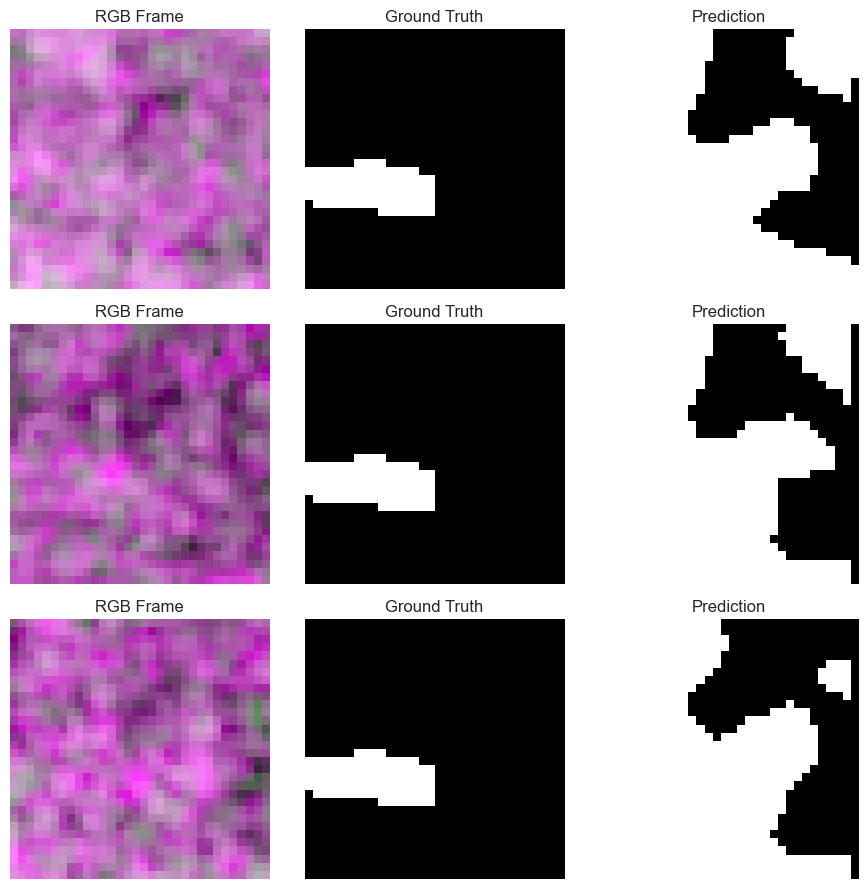

In [16]:
# — Visualize a few examples from the final validation pass —
batch = next(iter(val_loader))
data, masks = batch
data  = to_device(data, DEVICE)
masks = to_device(masks, DEVICE)

with torch.no_grad():
    logits     = model(data)
    probs      = nn.Softmax(dim=1)(logits)
    pred_masks = (probs[:,1] > 0.5).cpu().numpy()  # binary prediction

gt_masks = masks["crop_type"].cpu().numpy()

# extract last RGB frame per sample
imgs, dates = data[cfg.primary_sat]
imgs, dates = imgs.cpu().numpy(), dates.cpu().numpy()
rgb_idxs = SAT_METADATA[cfg.primary_sat]["rgb_bands"]
last_imgs = []
for seq, dt in zip(imgs, dates):
    idx = np.where(dt!=0)[0][-1]
    last_imgs.append(seq[idx][rgb_idxs].transpose(1,2,0))
last_imgs = np.stack(last_imgs)

# plot first 3 samples
n_vis = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n_vis, 3, figsize=(9, 3*n_vis))
for i in range(n_vis):
    # RGB
    ax = axes[i,0]
    img = last_imgs[i]
    ax.imshow((img - img.min())/(img.max()-img.min()))
    ax.set_title("RGB Frame"); ax.axis("off")

    # GT mask
    ax = axes[i,1]
    ax.imshow(gt_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Ground Truth"); ax.axis("off")

    # Pred mask
    ax = axes[i,2]
    ax.imshow(pred_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Prediction"); ax.axis("off")

plt.tight_layout()
plt.show()



Epoch 1/10


train: 100%|██████████| 18/18 [00:26<00:00,  1.46s/it, Loss=779.7430, gpu_mem=2.79 GB] 


Epoch time : 26.2s
 ▶ Train  RMSE:1147.3939, MAE:919.6290, MAPE:0.4863


Val_Crop_Yield: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it, Loss=813.4531, gpu_mem=2.79 GB]


 ▶ Val    RMSE:768.3381, MAE:607.9534, MAPE:0.3599
 ▶ Scatter R² = -0.2215


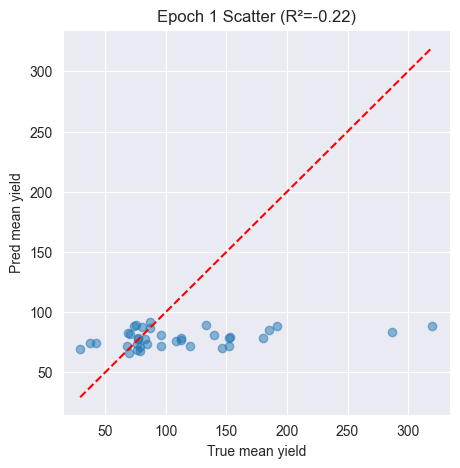

 ★ Improved MAE inf → 607.9534, saving checkpoint.

Epoch 2/10


train: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it, Loss=1071.6451, gpu_mem=2.79 GB]


Epoch time : 22.0s
 ▶ Train  RMSE:1141.3350, MAE:917.3254, MAPE:0.4846


Val_Crop_Yield: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s, Loss=821.1746, gpu_mem=2.79 GB]


 ▶ Val    RMSE:765.5170, MAE:607.3228, MAPE:0.3587
 ▶ Scatter R² = -0.2282


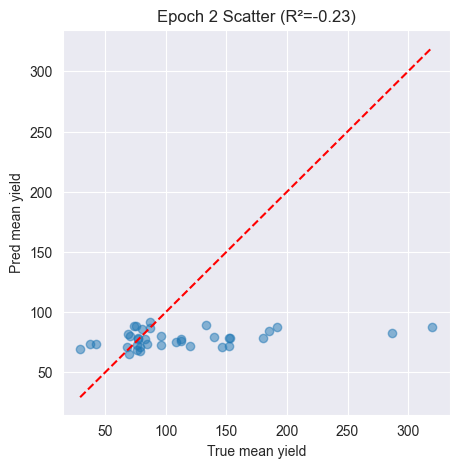

 ★ Improved MAE 607.9534 → 607.3228, saving checkpoint.

Epoch 3/10


train: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it, Loss=870.9149, gpu_mem=2.79 GB] 


Epoch time : 22.0s
 ▶ Train  RMSE:1143.8488, MAE:916.9584, MAPE:0.4844


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s, Loss=832.5541, gpu_mem=2.79 GB]


 ▶ Val    RMSE:771.9633, MAE:614.4489, MAPE:0.3628
 ▶ Scatter R² = -0.2325


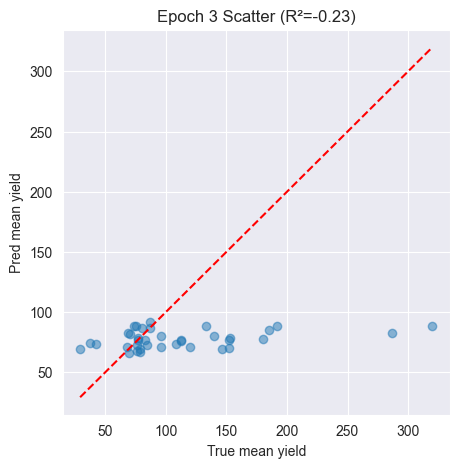


Epoch 4/10


train: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it, Loss=847.2365, gpu_mem=2.79 GB] 


Epoch time : 19.8s
 ▶ Train  RMSE:1136.1249, MAE:913.0788, MAPE:0.4821


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s, Loss=837.2999, gpu_mem=2.79 GB]


 ▶ Val    RMSE:775.7000, MAE:617.9598, MAPE:0.3649
 ▶ Scatter R² = -0.2357


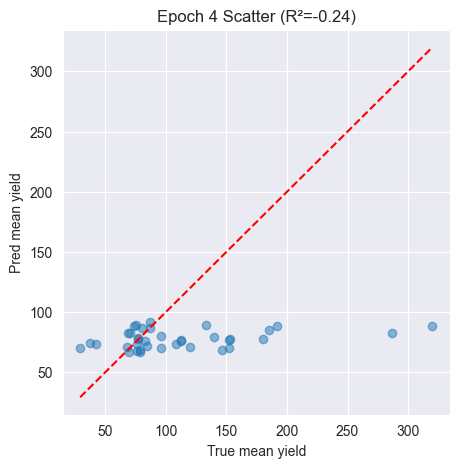


Epoch 5/10


train: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it, Loss=673.5005, gpu_mem=2.79 GB] 


Epoch time : 19.4s
 ▶ Train  RMSE:1144.2610, MAE:918.8918, MAPE:0.4858


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s, Loss=827.0598, gpu_mem=2.79 GB]


 ▶ Val    RMSE:773.4832, MAE:614.8962, MAPE:0.3640
 ▶ Scatter R² = -0.2269


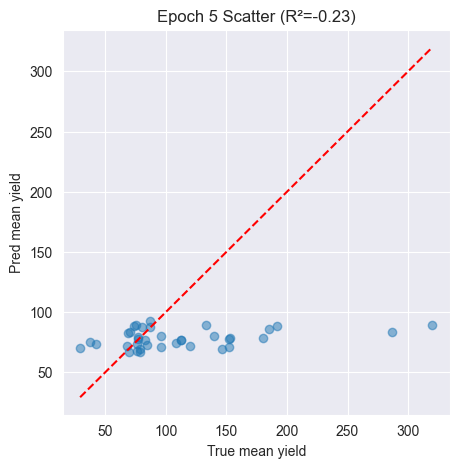


Epoch 6/10


train: 100%|██████████| 18/18 [00:17<00:00,  1.01it/s, Loss=924.1402, gpu_mem=2.79 GB] 


Epoch time : 17.9s
 ▶ Train  RMSE:1145.4275, MAE:920.2943, MAPE:0.4858


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s, Loss=817.5733, gpu_mem=2.79 GB]


 ▶ Val    RMSE:769.2069, MAE:610.3519, MAPE:0.3617
 ▶ Scatter R² = -0.2243


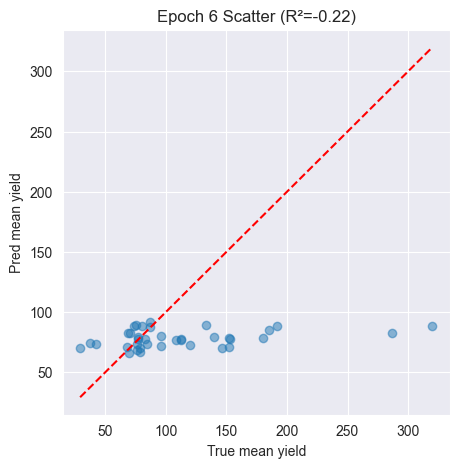


Epoch 7/10


train: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s, Loss=1172.6979, gpu_mem=2.79 GB]


Epoch time : 16.2s
 ▶ Train  RMSE:1145.6091, MAE:918.2657, MAPE:0.4855


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s, Loss=822.2941, gpu_mem=2.79 GB]


 ▶ Val    RMSE:774.6312, MAE:615.0638, MAPE:0.3647
 ▶ Scatter R² = -0.2241


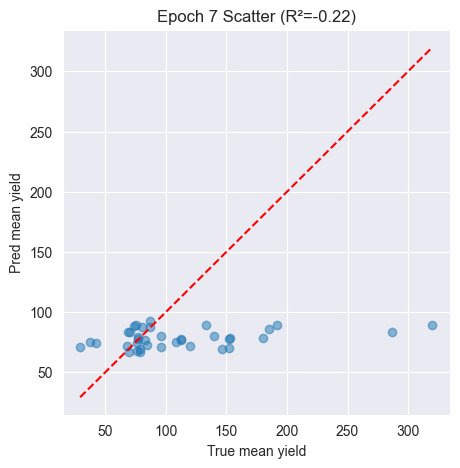


Epoch 8/10


train: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it, Loss=1403.4141, gpu_mem=2.79 GB]


Epoch time : 18.8s
 ▶ Train  RMSE:1150.0736, MAE:923.1021, MAPE:0.4874


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s, Loss=824.1515, gpu_mem=2.79 GB]


 ▶ Val    RMSE:773.3483, MAE:614.1950, MAPE:0.3639
 ▶ Scatter R² = -0.2260


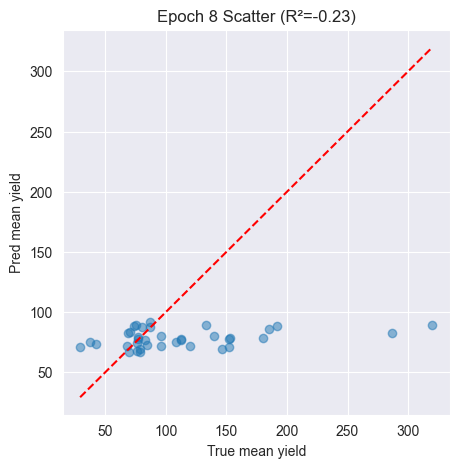


Epoch 9/10


train: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it, Loss=997.9615, gpu_mem=2.79 GB] 


Epoch time : 19.3s
 ▶ Train  RMSE:1139.8446, MAE:911.3877, MAPE:0.4812


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s, Loss=820.8221, gpu_mem=2.79 GB]


 ▶ Val    RMSE:769.9188, MAE:611.0306, MAPE:0.3619
 ▶ Scatter R² = -0.2258


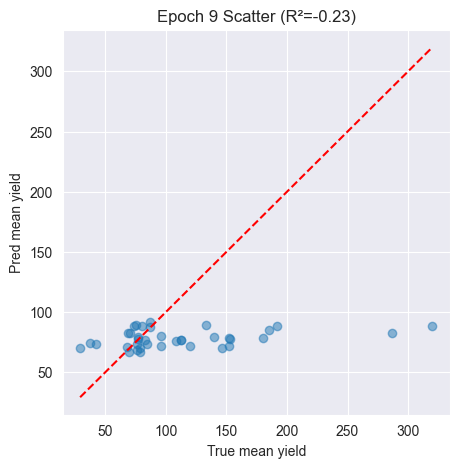


Epoch 10/10


train: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s, Loss=897.9717, gpu_mem=2.79 GB] 


Epoch time : 17.3s
 ▶ Train  RMSE:1142.0149, MAE:914.3384, MAPE:0.4834


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s, Loss=833.4966, gpu_mem=2.79 GB]


 ▶ Val    RMSE:779.0778, MAE:619.4100, MAPE:0.3668
 ▶ Scatter R² = -0.2305


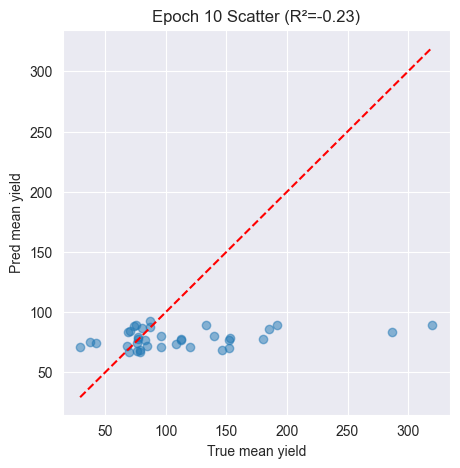


Training complete. Best MAE: tensor(607.3228, device='cuda:0')


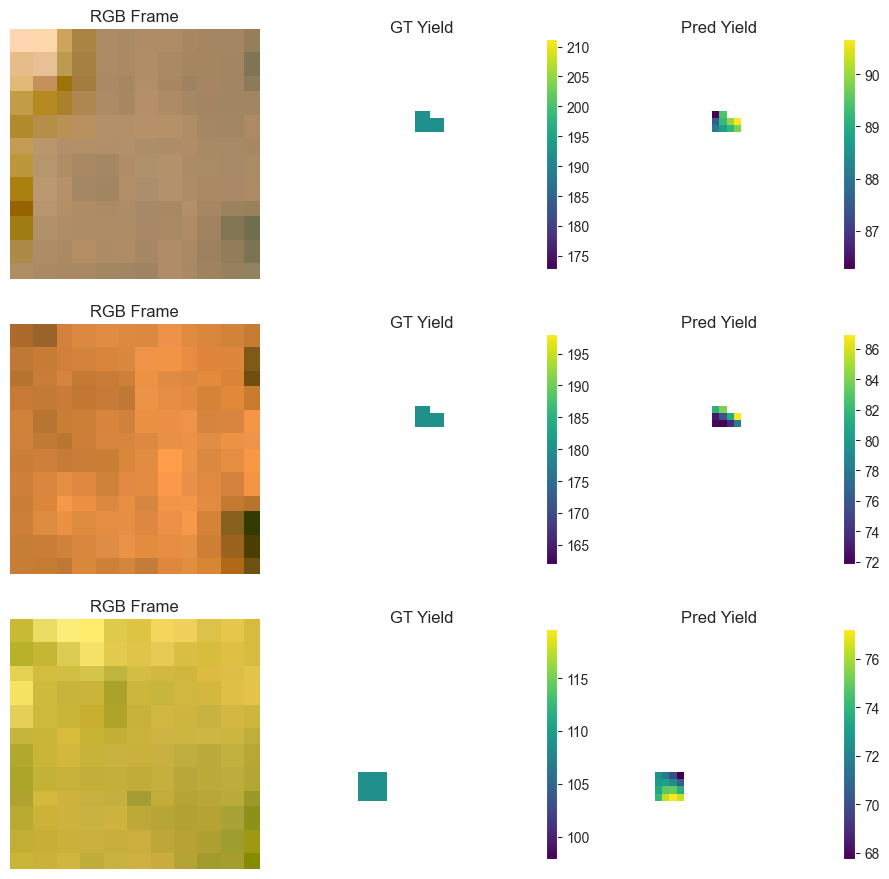

In [18]:
# 5) Full training loop with extended regression metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def to_device(batch, device):
    if isinstance(batch, torch.Tensor):
        return batch.to(device)
    if isinstance(batch, dict):
        return {k: to_device(v, device) for k, v in batch.items()}
    if isinstance(batch, (list, tuple)):
        return type(batch)(to_device(x, device) for x in batch)
    return batch

best_mae = float("inf")  # lower MAE is our deciding metric

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # — training —
    model.train()
    tr_loss, tr_metrics = train_iter(
        model, train_loader, criterion, optimizer,
        scheduler=scheduler, mode="train",
        device=DEVICE, task=TASK, CFG=cfg
    )
    print(f" ▶ Train  RMSE:{tr_metrics[0]:.4f}, MAE:{tr_metrics[1]:.4f}, MAPE:{tr_metrics[2]:.4f}")

    # — validation —
    model.eval()
    with torch.no_grad():
        vl_loss, vl_metrics = val_iter(
            model, val_loader, criterion, optimizer,
            mode="val", device=DEVICE, task=TASK,
            CFG=cfg, log=False
        )
    print(f" ▶ Val    RMSE:{vl_metrics[0]:.4f}, MAE:{vl_metrics[1]:.4f}, MAPE:{vl_metrics[2]:.4f}")

    # — scatter of per-plot mean yields & R² —
    preds_list, gts_list = [], []
    with torch.no_grad():
        for batch_data, batch_masks in val_loader:
            data  = to_device(batch_data, DEVICE)
            masks = to_device(batch_masks, DEVICE)

            y_pred = model(data)[:, 0]         # (B, H, W)
            gt     = masks["crop_yield"]       # (B, H, W)
            pm     = masks["plot_mask"].float()

            for yp, gt_i, pm_i in zip(y_pred, gt, pm):
                mask = pm_i > 0
                if mask.sum() > 0:
                    preds_list.append(yp[mask].mean().item())
                    gts_list.append(gt_i[mask].mean().item())

    r2 = r2_score(gts_list, preds_list)
    print(f" ▶ Scatter R² = {r2:.4f}")
    plt.figure(figsize=(5, 5))
    plt.scatter(gts_list, preds_list, alpha=0.5)
    mn, mx = min(gts_list), max(gts_list)
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("True mean yield")
    plt.ylabel("Pred mean yield")
    plt.title(f"Epoch {epoch} Scatter (R²={r2:.2f})")
    plt.show()

    # — save best by MAE —
    if vl_metrics[1] < best_mae:
        print(f" ★ Improved MAE {best_mae:.4f} → {vl_metrics[1]:.4f}, saving checkpoint.")
        best_mae = vl_metrics[1]
        torch.save({"model": model.state_dict()}, BEST_DIR/"checkpoint_best.pth.tar")

print("\nTraining complete. Best MAE:", best_mae)


# 6) Visualize a few validation examples
batch_data, batch_masks = next(iter(val_loader))
data  = to_device(batch_data, DEVICE)
masks = to_device(batch_masks, DEVICE)

with torch.no_grad():
    preds_map = model(data)[:, 0].cpu().numpy()    # (B, H, W)
gt_map   = masks["crop_yield"].cpu().numpy()       # (B, H, W)
pmask    = masks["plot_mask"].cpu().numpy() > 0    # (B, H, W)

# extract last RGB frames
imgs, dates = data[cfg.primary_sat]
imgs, dates = imgs.cpu().numpy(), dates.cpu().numpy()
rgb_bands   = SAT_METADATA[cfg.primary_sat]["rgb_bands"]
last_imgs   = np.stack([
    seq[np.where(dt != 0)[0][-1]][rgb_bands].transpose(1, 2, 0)
    for seq, dt in zip(imgs, dates)
])

# plot first 3 samples
n_vis = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n_vis, 3, figsize=(9, 3 * n_vis))

for i in range(n_vis):
    # RGB Frame
    ax = axes[i, 0]
    img = last_imgs[i]
    ax.imshow((img - img.min()) / (img.max() - img.min()))
    ax.set_title("RGB Frame")
    ax.axis("off")

    # Ground Truth Yield map
    ax = axes[i, 1]
    disp_gt = np.where(pmask[i], gt_map[i], np.nan)
    im1    = ax.imshow(disp_gt, cmap="viridis")
    ax.set_title("GT Yield")
    ax.axis("off")
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # Predicted Yield map
    ax = axes[i, 2]
    disp_pr = np.where(pmask[i], preds_map[i], np.nan)
    im2     = ax.imshow(disp_pr, cmap="viridis")
    ax.set_title("Pred Yield")
    ax.axis("off")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


### ConvLSTM

> Random seed fixed to 42
> Data sizes — train: 1937, val: 227, test: 206
> # params: 1983042


Val_Crop_Type: 100%|██████████| 15/15 [01:11<00:00,  4.78s/it, Loss=0.0033, gpu_mem=2.79 GB]



Validation (crop_type) → (tensor(0.8161, device='cuda:0'), tensor(0.8674, device='cuda:0'), tensor(0.7008, device='cuda:0'), tensor(0.7189, device='cuda:0'), tensor(0.9133, device='cuda:0'), tensor(0.7135, device='cuda:0'), tensor(0.9154, device='cuda:0'), tensor(0.5611, device='cuda:0'), tensor(0.8404, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))


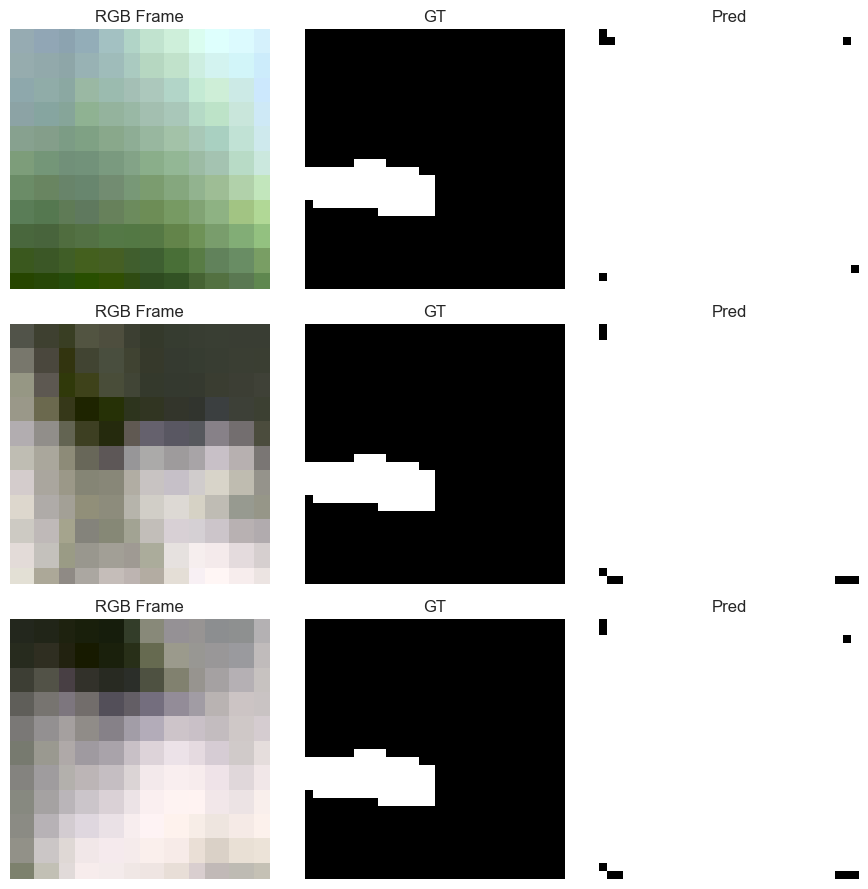

In [19]:
# ### ConvLSTM Fusion on [L8] for Crop Type ###

import numpy as np
import matplotlib.pyplot as plt

# 1) Configuration
TASK        = "crop_type"
SATELLITES  = ["L8"]
MODEL_NAME  = "convlstm"

# 2) Derived globals
REQUIRED_SAT_DATA = {s: SAT_METADATA[s] for s in SATELLITES}
RUN_DIR  = WEIGHTS_ROOT / TASK / f"[{','.join(SATELLITES)}]_{MODEL_NAME}"
BEST_DIR = RUN_DIR

# 3) Prepare data & model
set_seed(SEED)
train_loader, val_loader, _ = get_data_loaders()

model, cfg = build_model_and_cfg()
model.apply(weight_init)
print("> # params:", get_ntrainparams(model))

# 4) Optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX).to(DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# 5) Validation-only pass
ckpt = torch.load(BEST_DIR/"checkpoint_best.pth.tar", map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

val_loss, val_metrics, _ = val_iter(
    model, val_loader, criterion, optimizer,
    mode="val", device=DEVICE, task=TASK,
    log=True, CFG=cfg
)
print(f"\nValidation ({TASK}) →", val_metrics)

# 6) Visualize a few predictions
batch = next(iter(val_loader))
data, masks = batch
data  = to_device(data, DEVICE)
masks = to_device(masks, DEVICE)

with torch.no_grad():
    logits     = model(data)
    probs      = nn.Softmax(dim=1)(logits)
    pred_masks = (probs[:,1] > 0.5).cpu().numpy()

gt_masks = masks["crop_type"].cpu().numpy()

# extract last RGB frame for each sample
imgs, dates = data[cfg.primary_sat]
imgs, dates = imgs.cpu().numpy(), dates.cpu().numpy()
rgb_bands   = SAT_METADATA[cfg.primary_sat]["rgb_bands"]

last_imgs = []
for seq, dt in zip(imgs, dates):
    idx = np.where(dt!=0)[0][-1]
    last = seq[idx][rgb_bands].transpose(1,2,0)
    last_imgs.append(last)
last_imgs = np.stack(last_imgs)

# plot first 3 samples
n_vis = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n_vis, 3, figsize=(9, 3*n_vis))
for i in range(n_vis):
    # RGB
    ax = axes[i,0]
    img = last_imgs[i]
    ax.imshow((img - img.min())/(img.max()-img.min()))
    ax.set_title("RGB Frame"); ax.axis("off")

    # Ground truth mask
    ax = axes[i,1]
    ax.imshow(gt_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("GT"); ax.axis("off")

    # Predicted mask
    ax = axes[i,2]
    ax.imshow(pred_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Pred"); ax.axis("off")

plt.tight_layout()
plt.show()



Epoch 1/10


train: 100%|██████████| 122/122 [02:08<00:00,  1.05s/it, Loss=15.2602, gpu_mem=2.99 GB]


Epoch time : 128.4s
 ▶ Train metrics: (tensor(0.5834, device='cuda:0'), tensor(0.6150, device='cuda:0'), tensor(0.4212, device='cuda:0'), tensor(0.4688, device='cuda:0'), tensor(0.6981, device='cuda:0'), tensor(0.4527, device='cuda:0'), tensor(0.7125, device='cuda:0'), tensor(0.3061, device='cuda:0'), tensor(0.5362, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s, Loss=0.0024, gpu_mem=2.99 GB]


 ▶ Val metrics:   (tensor(0.8331, device='cuda:0'), tensor(0.8782, device='cuda:0'), tensor(0.7234, device='cuda:0'), tensor(0.7462, device='cuda:0'), tensor(0.9199, device='cuda:0'), tensor(0.7541, device='cuda:0'), tensor(0.9169, device='cuda:0'), tensor(0.5952, device='cuda:0'), tensor(0.8516, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.74      0.75      0.75      2342
       Paddy       0.92      0.92      0.92      7518

    accuracy                           0.88      9860
   macro avg       0.83      0.84      0.83      9860
weighted avg       0.88      0.88      0.88      9860



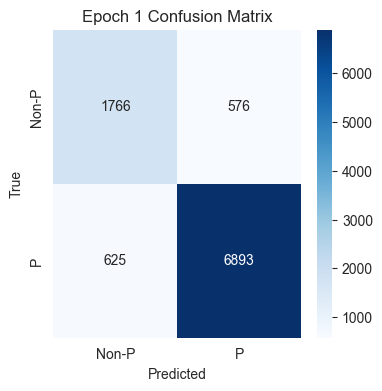

 ★ Improved (0.0000 → 0.8331), saving.

Epoch 2/10


train: 100%|██████████| 122/122 [01:49<00:00,  1.11it/s, Loss=0.1583, gpu_mem=3.04 GB]


Epoch time : 109.6s
 ▶ Train metrics: (tensor(0.5868, device='cuda:0'), tensor(0.6092, device='cuda:0'), tensor(0.4218, device='cuda:0'), tensor(0.4904, device='cuda:0'), tensor(0.6831, device='cuda:0'), tensor(0.5011, device='cuda:0'), tensor(0.6742, device='cuda:0'), tensor(0.3249, device='cuda:0'), tensor(0.5188, device='cuda:0'), (tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s, Loss=1.0823, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.6514, device='cuda:0'), tensor(0.7812, device='cuda:0'), tensor(0.5209, device='cuda:0'), tensor(0.4387, device='cuda:0'), tensor(0.8641, device='cuda:0'), tensor(0.3599, device='cuda:0'), tensor(0.9125, device='cuda:0'), tensor(0.2810, device='cuda:0'), tensor(0.7608, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.56      0.36      0.44      2342
       Paddy       0.82      0.91      0.86      7518

    accuracy                           0.78      9860
   macro avg       0.69      0.64      0.65      9860
weighted avg       0.76      0.78      0.76      9860



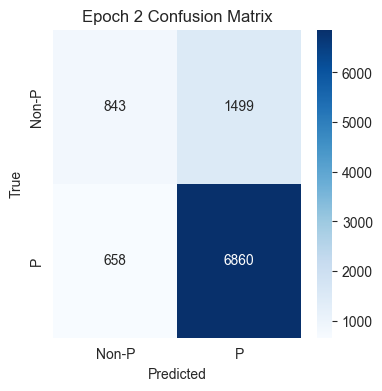


Epoch 3/10


train: 100%|██████████| 122/122 [01:49<00:00,  1.11it/s, Loss=0.8635, gpu_mem=3.04 GB]


Epoch time : 110.0s
 ▶ Train metrics: (tensor(0.5563, device='cuda:0'), tensor(0.5982, device='cuda:0'), tensor(0.3978, device='cuda:0'), tensor(0.4199, device='cuda:0'), tensor(0.6927, device='cuda:0'), tensor(0.3875, device='cuda:0'), tensor(0.7248, device='cuda:0'), tensor(0.2657, device='cuda:0'), tensor(0.5299, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s, Loss=1.4804, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.6597, device='cuda:0'), tensor(0.7878, device='cuda:0'), tensor(0.5293, device='cuda:0'), tensor(0.4509, device='cuda:0'), tensor(0.8685, device='cuda:0'), tensor(0.3668, device='cuda:0'), tensor(0.9190, device='cuda:0'), tensor(0.2911, device='cuda:0'), tensor(0.7676, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.59      0.37      0.45      2342
       Paddy       0.82      0.92      0.87      7518

    accuracy                           0.79      9860
   macro avg       0.70      0.64      0.66      9860
weighted avg       0.77      0.79      0.77      9860



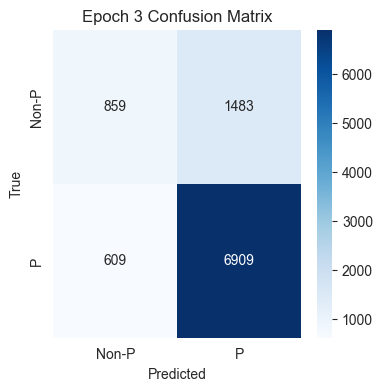


Epoch 4/10


train: 100%|██████████| 122/122 [03:27<00:00,  1.70s/it, Loss=5.8905, gpu_mem=3.04 GB]


Epoch time : 207.1s
 ▶ Train metrics: (tensor(0.5595, device='cuda:0'), tensor(0.5981, device='cuda:0'), tensor(0.3999, device='cuda:0'), tensor(0.4292, device='cuda:0'), tensor(0.6899, device='cuda:0'), tensor(0.4026, device='cuda:0'), tensor(0.7155, device='cuda:0'), tensor(0.2732, device='cuda:0'), tensor(0.5266, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:23<00:00,  1.56s/it, Loss=2.7103, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.5888, device='cuda:0'), tensor(0.7696, device='cuda:0'), tensor(0.4722, device='cuda:0'), tensor(0.3161, device='cuda:0'), tensor(0.8614, device='cuda:0'), tensor(0.2242, device='cuda:0'), tensor(0.9395, device='cuda:0'), tensor(0.1877, device='cuda:0'), tensor(0.7566, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.54      0.22      0.32      2342
       Paddy       0.80      0.94      0.86      7518

    accuracy                           0.77      9860
   macro avg       0.67      0.58      0.59      9860
weighted avg       0.73      0.77      0.73      9860



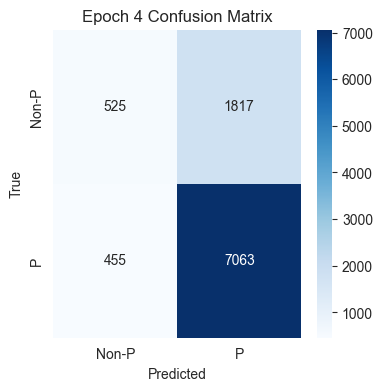


Epoch 5/10


train: 100%|██████████| 122/122 [02:10<00:00,  1.07s/it, Loss=4.5284, gpu_mem=3.04 GB]


Epoch time : 130.9s
 ▶ Train metrics: (tensor(0.5786, device='cuda:0'), tensor(0.6138, device='cuda:0'), tensor(0.4175, device='cuda:0'), tensor(0.4567, device='cuda:0'), tensor(0.7005, device='cuda:0'), tensor(0.4326, device='cuda:0'), tensor(0.7226, device='cuda:0'), tensor(0.2960, device='cuda:0'), tensor(0.5390, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s, Loss=0.2136, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.5260, device='cuda:0'), tensor(0.5575, device='cuda:0'), tensor(0.3663, device='cuda:0'), tensor(0.4039, device='cuda:0'), tensor(0.6482, device='cuda:0'), tensor(0.6311, device='cuda:0'), tensor(0.5346, device='cuda:0'), tensor(0.2530, device='cuda:0'), tensor(0.4795, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.30      0.63      0.40      2342
       Paddy       0.82      0.53      0.65      7518

    accuracy                           0.56      9860
   macro avg       0.56      0.58      0.53      9860
weighted avg       0.70      0.56      0.59      9860



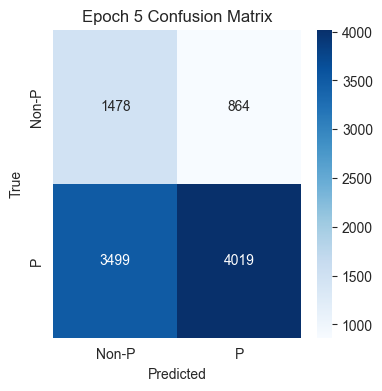


Epoch 6/10


train: 100%|██████████| 122/122 [01:50<00:00,  1.11it/s, Loss=0.8561, gpu_mem=3.04 GB]


Epoch time : 110.3s
 ▶ Train metrics: (tensor(0.5532, device='cuda:0'), tensor(0.6031, device='cuda:0'), tensor(0.3972, device='cuda:0'), tensor(0.4039, device='cuda:0'), tensor(0.7025, device='cuda:0'), tensor(0.3584, device='cuda:0'), tensor(0.7500, device='cuda:0'), tensor(0.2530, device='cuda:0'), tensor(0.5414, device='cuda:0'), (tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s, Loss=1.1384, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.7048, device='cuda:0'), tensor(0.8204, device='cuda:0'), tensor(0.5763, device='cuda:0'), tensor(0.5202, device='cuda:0'), tensor(0.8895, device='cuda:0'), tensor(0.4099, device='cuda:0'), tensor(0.9483, device='cuda:0'), tensor(0.3515, device='cuda:0'), tensor(0.8010, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.71      0.41      0.52      2342
       Paddy       0.84      0.95      0.89      7518

    accuracy                           0.82      9860
   macro avg       0.77      0.68      0.70      9860
weighted avg       0.81      0.82      0.80      9860



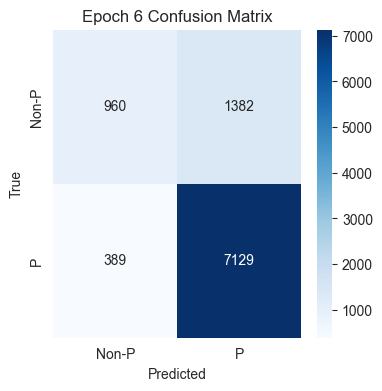


Epoch 7/10


train: 100%|██████████| 122/122 [01:50<00:00,  1.10it/s, Loss=0.1473, gpu_mem=3.04 GB]


Epoch time : 110.5s
 ▶ Train metrics: (tensor(0.5964, device='cuda:0'), tensor(0.6329, device='cuda:0'), tensor(0.4356, device='cuda:0'), tensor(0.4749, device='cuda:0'), tensor(0.7178, device='cuda:0'), tensor(0.4425, device='cuda:0'), tensor(0.7472, device='cuda:0'), tensor(0.3114, device='cuda:0'), tensor(0.5598, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s, Loss=1.1134, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.5532, device='cuda:0'), tensor(0.7768, device='cuda:0'), tensor(0.4516, device='cuda:0'), tensor(0.2371, device='cuda:0'), tensor(0.8693, device='cuda:0'), tensor(0.1460, device='cuda:0'), tensor(0.9733, device='cuda:0'), tensor(0.1345, device='cuda:0'), tensor(0.7688, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.63      0.15      0.24      2342
       Paddy       0.79      0.97      0.87      7518

    accuracy                           0.78      9860
   macro avg       0.71      0.56      0.55      9860
weighted avg       0.75      0.78      0.72      9860



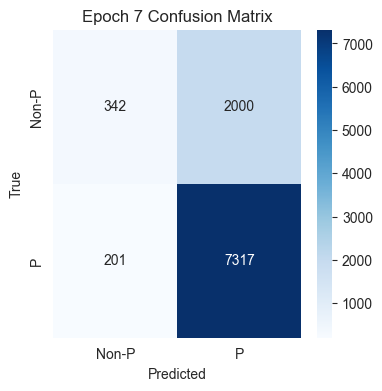


Epoch 8/10


train: 100%|██████████| 122/122 [01:50<00:00,  1.11it/s, Loss=0.2146, gpu_mem=3.04 GB]


Epoch time : 110.0s
 ▶ Train metrics: (tensor(0.5617, device='cuda:0'), tensor(0.6240, device='cuda:0'), tensor(0.4091, device='cuda:0'), tensor(0.3963, device='cuda:0'), tensor(0.7270, device='cuda:0'), tensor(0.3290, device='cuda:0'), tensor(0.8012, device='cuda:0'), tensor(0.2472, device='cuda:0'), tensor(0.5711, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([0, 0, 0,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s, Loss=1.0190, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.6610, device='cuda:0'), tensor(0.8082, device='cuda:0'), tensor(0.5365, device='cuda:0'), tensor(0.4377, device='cuda:0'), tensor(0.8844, device='cuda:0'), tensor(0.3143, device='cuda:0'), tensor(0.9621, device='cuda:0'), tensor(0.2802, device='cuda:0'), tensor(0.7927, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.72      0.31      0.44      2342
       Paddy       0.82      0.96      0.88      7518

    accuracy                           0.81      9860
   macro avg       0.77      0.64      0.66      9860
weighted avg       0.80      0.81      0.78      9860



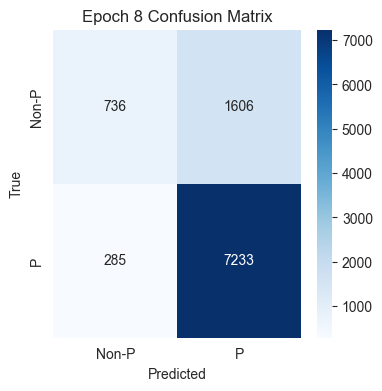


Epoch 9/10


train: 100%|██████████| 122/122 [01:55<00:00,  1.06it/s, Loss=2.9656, gpu_mem=3.04 GB]


Epoch time : 115.3s
 ▶ Train metrics: (tensor(0.5806, device='cuda:0'), tensor(0.6378, device='cuda:0'), tensor(0.4260, device='cuda:0'), tensor(0.4256, device='cuda:0'), tensor(0.7355, device='cuda:0'), tensor(0.3577, device='cuda:0'), tensor(0.8060, device='cuda:0'), tensor(0.2704, device='cuda:0'), tensor(0.5817, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s, Loss=0.9999, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.6512, device='cuda:0'), tensor(0.8061, device='cuda:0'), tensor(0.5282, device='cuda:0'), tensor(0.4188, device='cuda:0'), tensor(0.8836, device='cuda:0'), tensor(0.2942, device='cuda:0'), tensor(0.9655, device='cuda:0'), tensor(0.2649, device='cuda:0'), tensor(0.7915, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.73      0.29      0.42      2342
       Paddy       0.81      0.97      0.88      7518

    accuracy                           0.81      9860
   macro avg       0.77      0.63      0.65      9860
weighted avg       0.79      0.81      0.77      9860



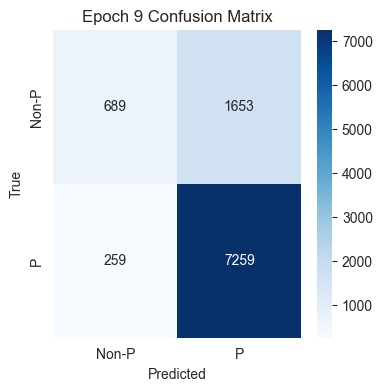


Epoch 10/10


train: 100%|██████████| 122/122 [01:55<00:00,  1.06it/s, Loss=0.2654, gpu_mem=3.04 GB]


Epoch time : 115.5s
 ▶ Train metrics: (tensor(0.6145, device='cuda:0'), tensor(0.6485, device='cuda:0'), tensor(0.4534, device='cuda:0'), tensor(0.5000, device='cuda:0'), tensor(0.7289, device='cuda:0'), tensor(0.4685, device='cuda:0'), tensor(0.7565, device='cuda:0'), tensor(0.3333, device='cuda:0'), tensor(0.5735, device='cuda:0'), (tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0'), tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')))


Val_Crop_Type: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s, Loss=0.9525, gpu_mem=3.04 GB]


 ▶ Val metrics:   (tensor(0.7279, device='cuda:0'), tensor(0.8376, device='cuda:0'), tensor(0.6018, device='cuda:0'), tensor(0.5552, device='cuda:0'), tensor(0.9007, device='cuda:0'), tensor(0.4266, device='cuda:0'), tensor(0.9657, device='cuda:0'), tensor(0.3842, device='cuda:0'), tensor(0.8193, device='cuda:0'), (tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'), tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')))

Classification Report:
              precision    recall  f1-score   support

   Non-Paddy       0.79      0.43      0.56      2342
       Paddy       0.84      0.97      0.90      7518

    accuracy                           0.84      9860
   macro avg       0.82      0.70      0.73      9860
weighted avg       0.83      0.84      0.82      9860



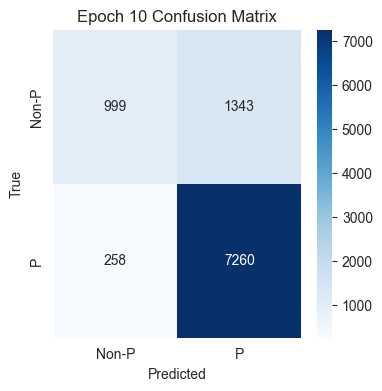


Training complete. Best metric: tensor(0.8331, device='cuda:0')


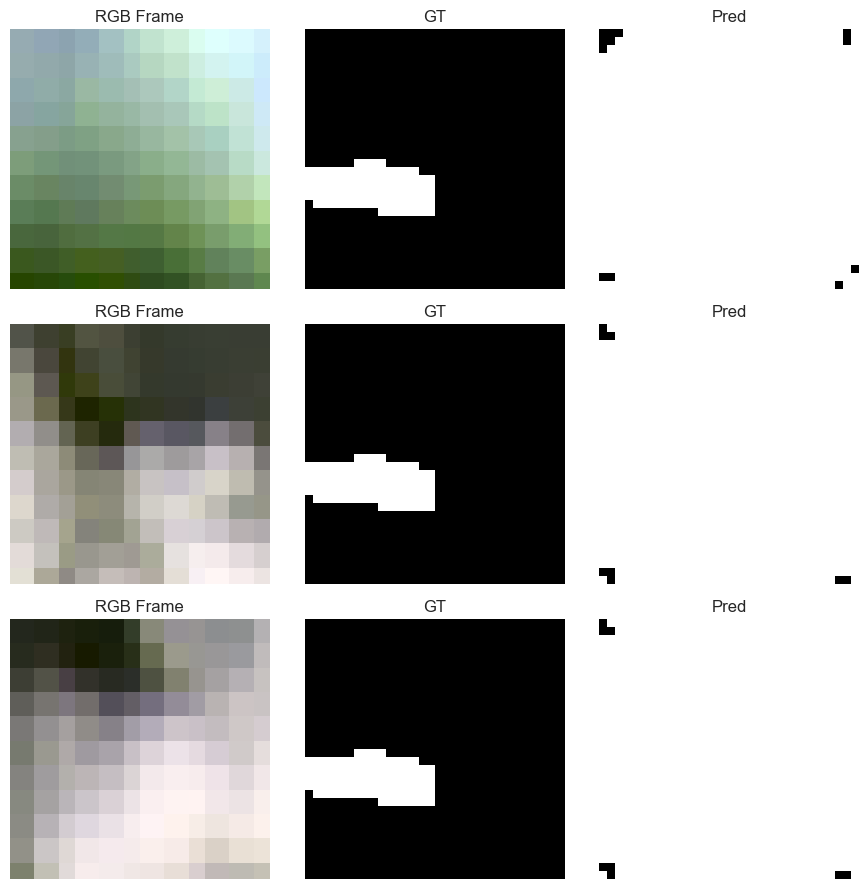

In [20]:
# 6) Full Training with Extended Metrics & Visualization

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def to_device(batch, device):
    if isinstance(batch, torch.Tensor):
        return batch.to(device)
    if isinstance(batch, dict):
        return {k: to_device(v, device) for k, v in batch.items()}
    return [to_device(x, device) for x in batch]

best_metric = 0.0

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # — Train step —
    model.train()
    tr_loss, tr_metrics = train_iter(
        model, train_loader, criterion, optimizer,
        scheduler=scheduler, mode="train",
        device=DEVICE, task=TASK, CFG=cfg
    )
    print(" ▶ Train metrics:", tr_metrics)

    # — Validation step —
    model.eval()
    with torch.no_grad():
        vl_loss, vl_metrics = val_iter(
            model, val_loader, criterion, optimizer,
            mode="val", device=DEVICE, task=TASK,
            CFG=cfg, log=False
        )
    print(" ▶ Val metrics:  ", vl_metrics)

    # — Classification report & confusion matrix —
    all_preds, all_gts = [], []
    with torch.no_grad():
        for data, masks in val_loader:
            data  = to_device(data, DEVICE)
            masks = to_device(masks, DEVICE)

            logits = model(data)
            probs  = nn.Softmax(dim=1)(logits)
            preds  = torch.argmax(probs, dim=1).cpu().numpy().ravel()
            gts    = masks["crop_type"].long().cpu().numpy().ravel()

            valid = (gts != IGNORE_INDEX)
            all_preds.extend(preds[valid])
            all_gts.extend(gts[valid])

    print("\nClassification Report:")
    print(classification_report(all_gts, all_preds, target_names=["Non-Paddy", "Paddy"]))

    cm = confusion_matrix(all_gts, all_preds)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-P", "P"], yticklabels=["Non-P", "P"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Epoch {epoch} Confusion Matrix")
    plt.show()

    # — Save best model —
    curr = vl_metrics[0]
    if curr > best_metric:
        print(f" ★ Improved ({best_metric:.4f} → {curr:.4f}), saving.")
        best_metric = curr
        torch.save({"model": model.state_dict()}, BEST_DIR/"checkpoint_best.pth.tar")

print("\nTraining complete. Best metric:", best_metric)


# 7) Visualize Examples from Final Validation Batch

batch = next(iter(val_loader))
data, masks = batch
data  = to_device(data, DEVICE)
masks = to_device(masks, DEVICE)

with torch.no_grad():
    logits     = model(data)
    probs      = nn.Softmax(dim=1)(logits)
    pred_masks = (probs[:,1] > 0.5).cpu().numpy()

gt_masks = masks["crop_type"].cpu().numpy()

# Extract last available RGB frame per sample
imgs, dates = data[cfg.primary_sat]
imgs, dates = imgs.cpu().numpy(), dates.cpu().numpy()
rgb_bands   = SAT_METADATA[cfg.primary_sat]["rgb_bands"]

last_imgs = []
for seq, dt in zip(imgs, dates):
    idx = np.where(dt != 0)[0][-1]
    last = seq[idx][rgb_bands].transpose(1, 2, 0)
    last_imgs.append(last)
last_imgs = np.stack(last_imgs)

# Plot first 3 samples
n_vis = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n_vis, 3, figsize=(9, 3 * n_vis))

for i in range(n_vis):
    # RGB Frame
    ax = axes[i, 0]
    img = last_imgs[i]
    ax.imshow((img - img.min()) / (img.max() - img.min()))
    ax.set_title("RGB Frame")
    ax.axis("off")

    # Ground Truth Mask
    ax = axes[i, 1]
    ax.imshow(gt_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("GT")
    ax.axis("off")

    # Predicted Mask
    ax = axes[i, 2]
    ax.imshow(pred_masks[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("Pred")
    ax.axis("off")

plt.tight_layout()
plt.show()


> Random seed fixed to 42
> Data sizes — train: 282, val: 37, test: 0
> # params: 1982897


Val_Crop_Yield: 100%|██████████| 3/3 [00:10<00:00,  3.66s/it, Loss=732.8892, gpu_mem=3.04 GB] 



Initial validation → RMSE:805.6158, MAE:588.8393, MAPE:0.3633



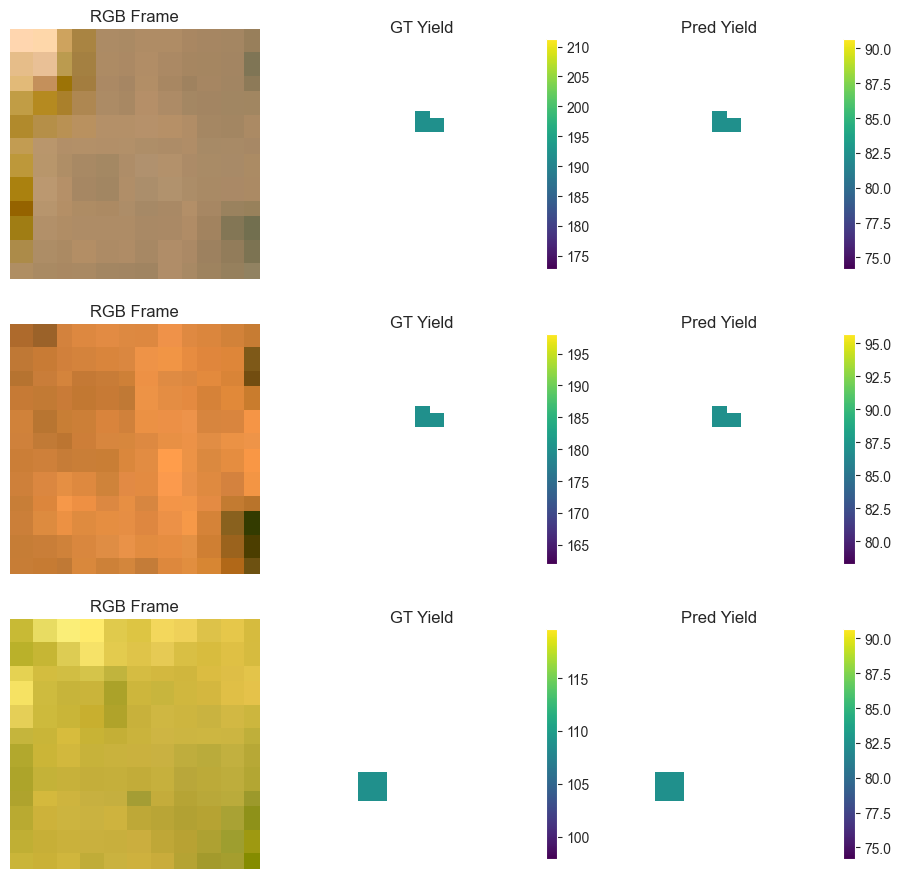

In [21]:
# ### ConvLSTM Fusion for [L8] – Crop Yield Regression ###

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# 1) Configuration
TASK        = "crop_yield"
SATELLITES  = ["L8"]
MODEL_NAME  = "convlstm"

# 2) Derived globals
REQUIRED_SAT_DATA = {s: SAT_METADATA[s] for s in SATELLITES}
RUN_DIR   = WEIGHTS_ROOT / TASK / f"[{','.join(SATELLITES)}]_{MODEL_NAME}"
BEST_DIR  = RUN_DIR

# 3) Prepare data & model
set_seed(SEED)
train_loader, val_loader, _ = get_data_loaders()
model, cfg = build_model_and_cfg()
model.apply(weight_init)
print("> # params:", get_ntrainparams(model))

# 4) Optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = RMSELoss(ignore_index=IGNORE_INDEX).to(DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# 5) Initial validation
ckpt = torch.load(BEST_DIR/"checkpoint_best.pth.tar", map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()
vloss, vmetrics, _ = val_iter(
    model, val_loader, criterion, optimizer,
    mode="val", device=DEVICE, task=TASK,
    log=True, CFG=cfg
)
print(f"\nInitial validation → RMSE:{vmetrics[0]:.4f}, MAE:{vmetrics[1]:.4f}, MAPE:{vmetrics[2]:.4f}\n")

# 6) Visualize a few validation examples
batch = next(iter(val_loader))
data, masks = batch

# move to device
data  = {s: to_device(v, DEVICE) for s, v in data.items()}
masks = {k: to_device(v, DEVICE) for k, v in masks.items()}

with torch.no_grad():
    preds_map = model(data)[:, 0].cpu().numpy()
gt_map   = masks["crop_yield"].cpu().numpy()
pmask    = masks["plot_mask"].cpu().numpy() > 0

# extract last RGB frame
imgs, dates = data[cfg.primary_sat]
imgs, dates = imgs.cpu().numpy(), dates.cpu().numpy()
rgb_bands   = SAT_METADATA[cfg.primary_sat]["rgb_bands"]
last_imgs   = np.stack([
    seq[np.where(dt!=0)[0][-1]][rgb_bands].transpose(1, 2, 0)
    for seq, dt in zip(imgs, dates)
])

# plot first 3 samples
n_vis = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n_vis, 3, figsize=(9, 3 * n_vis))

for i in range(n_vis):
    # RGB Frame
    ax = axes[i, 0]
    img = last_imgs[i]
    ax.imshow((img - img.min()) / (img.max() - img.min()))
    ax.set_title("RGB Frame")
    ax.axis("off")

    # Ground Truth Yield
    ax = axes[i, 1]
    disp = np.where(pmask[i], gt_map[i], np.nan)
    im = ax.imshow(disp, cmap="viridis")
    ax.set_title("GT Yield")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Predicted Yield
    ax = axes[i, 2]
    disp2 = np.where(pmask[i], preds_map[i], np.nan)
    im2 = ax.imshow(disp2, cmap="viridis")
    ax.set_title("Pred Yield")
    ax.axis("off")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



Epoch 1/10


train: 100%|██████████| 18/18 [00:12<00:00,  1.42it/s, Loss=1071.1497, gpu_mem=3.04 GB]


Epoch time : 12.7s
 ▶ Train  RMSE:1155.2650, MAE:927.2136, MAPE:0.4897


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s, Loss=724.4530, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:807.7150, MAE:588.8766, MAPE:0.3636
 ▶ Scatter R² = -0.2115


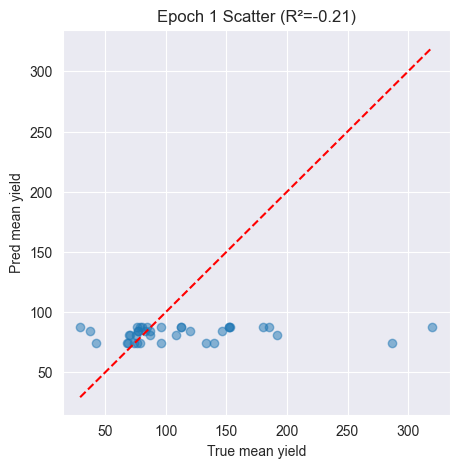

 ★ Improved MAE inf → 588.8766, saving checkpoint.

Epoch 2/10


train: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s, Loss=2061.7817, gpu_mem=3.04 GB]


Epoch time : 13.4s
 ▶ Train  RMSE:1144.5490, MAE:924.3724, MAPE:0.4855


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s, Loss=727.3832, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:813.3502, MAE:602.7680, MAPE:0.3687
 ▶ Scatter R² = -0.2748


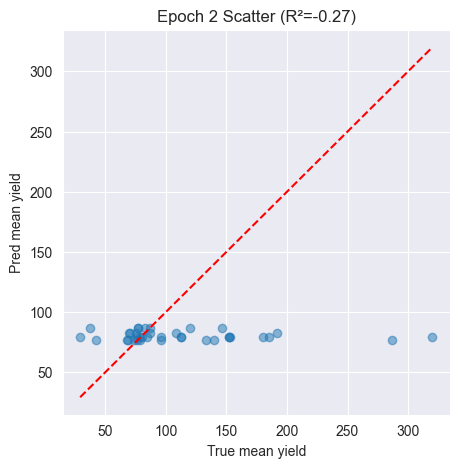


Epoch 3/10


train: 100%|██████████| 18/18 [00:13<00:00,  1.30it/s, Loss=825.1232, gpu_mem=3.04 GB] 


Epoch time : 13.8s
 ▶ Train  RMSE:1135.6115, MAE:909.4492, MAPE:0.4820


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, Loss=665.9233, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:822.0643, MAE:600.8889, MAPE:0.3759
 ▶ Scatter R² = -0.1903


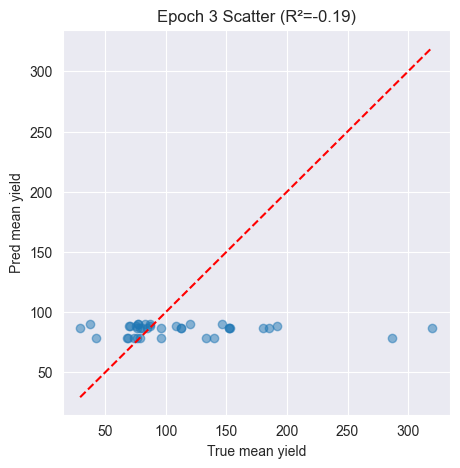


Epoch 4/10


train: 100%|██████████| 18/18 [00:12<00:00,  1.39it/s, Loss=1038.4860, gpu_mem=3.04 GB]


Epoch time : 12.9s
 ▶ Train  RMSE:1139.3591, MAE:914.8528, MAPE:0.4835


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s, Loss=680.1927, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:820.4453, MAE:608.7137, MAPE:0.3781
 ▶ Scatter R² = -0.2214


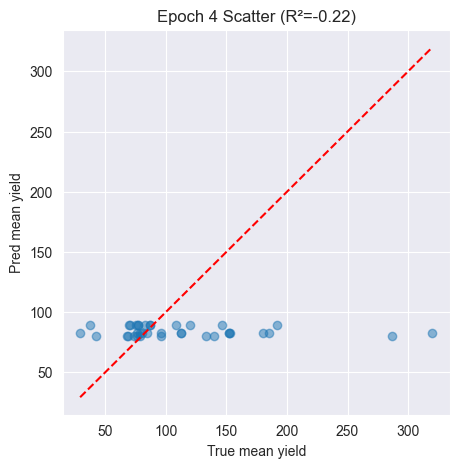


Epoch 5/10


train: 100%|██████████| 18/18 [00:11<00:00,  1.51it/s, Loss=1355.5149, gpu_mem=3.04 GB]


Epoch time : 11.9s
 ▶ Train  RMSE:1132.4573, MAE:905.7016, MAPE:0.4783


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s, Loss=683.6923, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:817.6571, MAE:601.6155, MAPE:0.3749
 ▶ Scatter R² = -0.2018


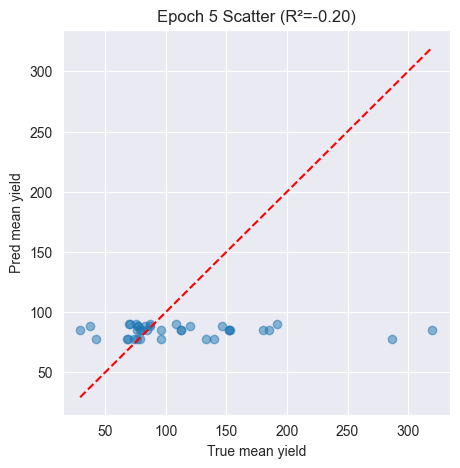


Epoch 6/10


train: 100%|██████████| 18/18 [00:13<00:00,  1.37it/s, Loss=2208.0947, gpu_mem=3.04 GB]


Epoch time : 13.1s
 ▶ Train  RMSE:1134.9806, MAE:912.1351, MAPE:0.4818


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s, Loss=740.1628, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:808.8656, MAE:599.3490, MAPE:0.3674
 ▶ Scatter R² = -0.2594


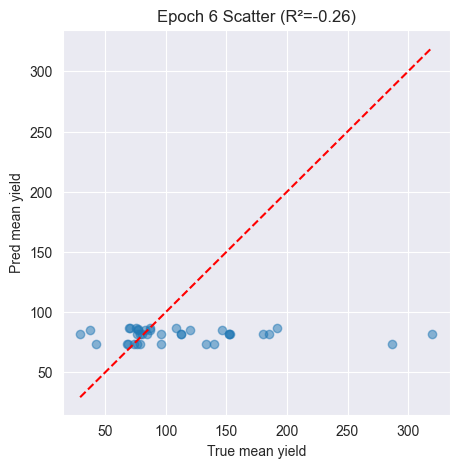


Epoch 7/10


train: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s, Loss=1125.4518, gpu_mem=3.04 GB]


Epoch time : 15.9s
 ▶ Train  RMSE:1146.0856, MAE:919.2241, MAPE:0.4846


Val_Crop_Yield: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it, Loss=704.7757, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:817.0719, MAE:603.7754, MAPE:0.3725
 ▶ Scatter R² = -0.2498


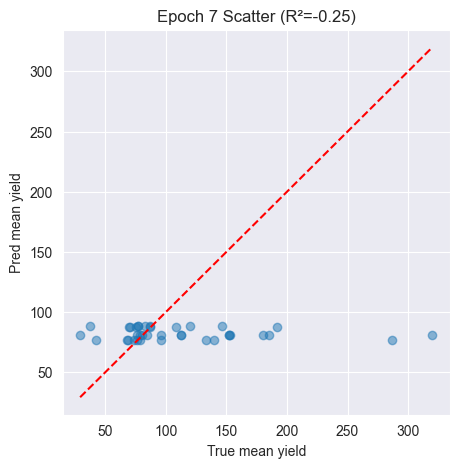


Epoch 8/10


train: 100%|██████████| 18/18 [00:20<00:00,  1.17s/it, Loss=962.3586, gpu_mem=3.04 GB] 


Epoch time : 21.0s
 ▶ Train  RMSE:1131.2335, MAE:907.4839, MAPE:0.4797


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s, Loss=690.0329, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:818.3043, MAE:601.4987, MAPE:0.3730
 ▶ Scatter R² = -0.2275


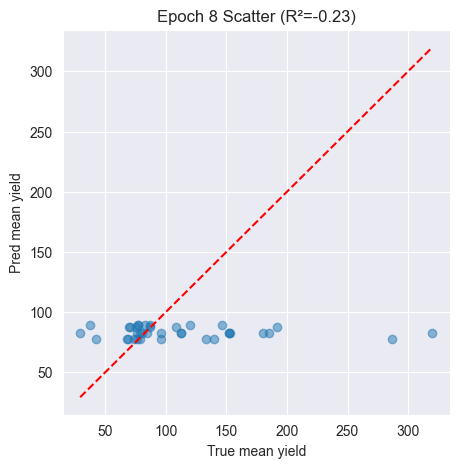


Epoch 9/10


train: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s, Loss=1421.9630, gpu_mem=3.04 GB]


Epoch time : 14.8s
 ▶ Train  RMSE:1126.9789, MAE:902.5110, MAPE:0.4785


Val_Crop_Yield: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s, Loss=700.6592, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:815.1942, MAE:598.5670, MAPE:0.3706
 ▶ Scatter R² = -0.2274


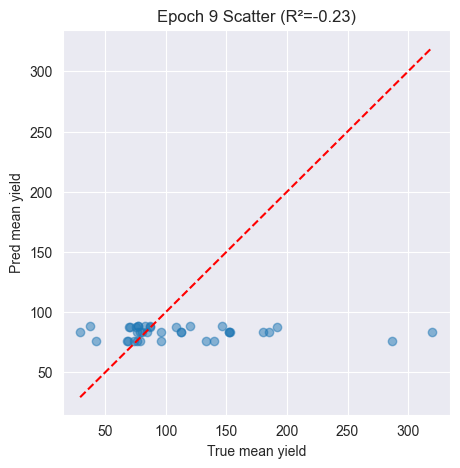


Epoch 10/10


train: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it, Loss=932.4342, gpu_mem=3.04 GB] 


Epoch time : 19.9s
 ▶ Train  RMSE:1129.6475, MAE:903.6655, MAPE:0.4768


Val_Crop_Yield: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s, Loss=707.7888, gpu_mem=3.04 GB] 


 ▶ Val    RMSE:813.9533, MAE:598.3527, MAPE:0.3696
 ▶ Scatter R² = -0.2349


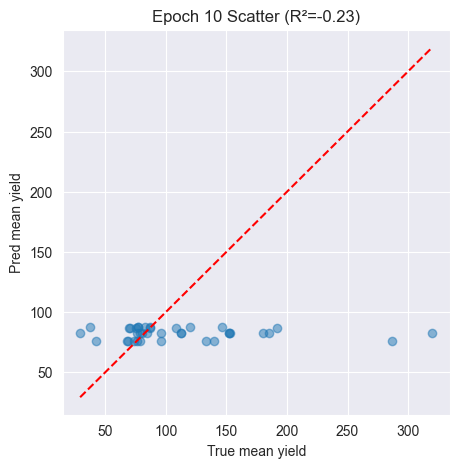


Training complete. Best MAE: tensor(588.8766, device='cuda:0')


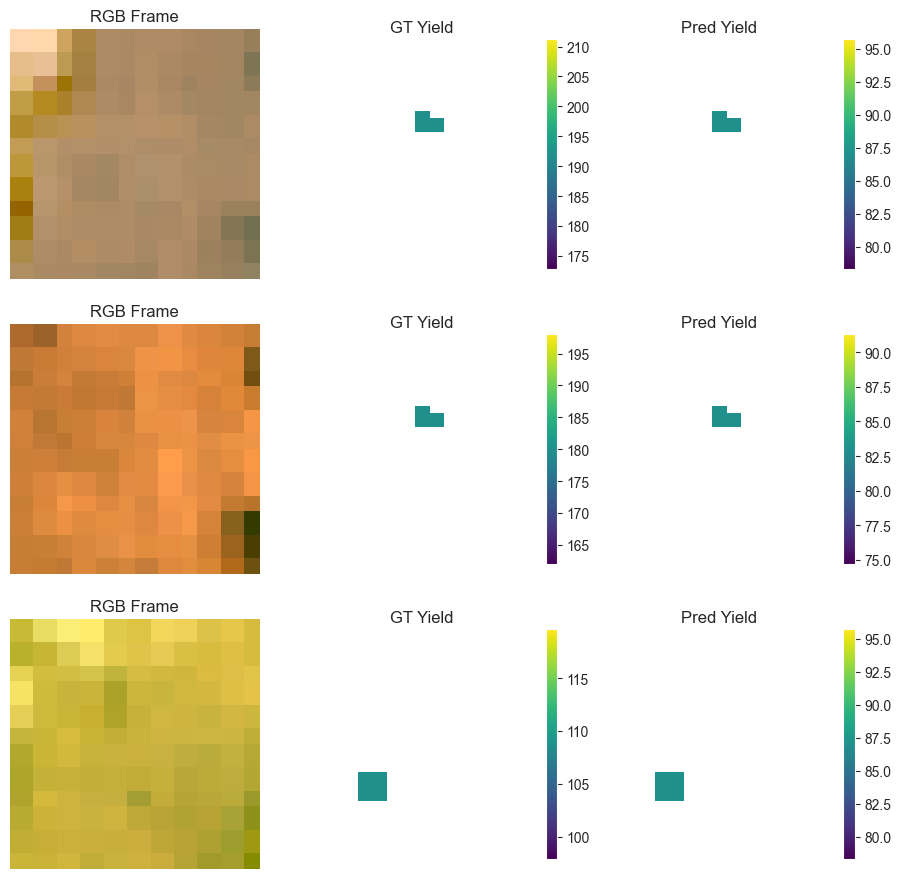

In [22]:
# 5) Full training loop with extended regression metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

best_mae = float("inf")  # lower MAE is our deciding metric

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # — training —
    model.train()
    tr_loss, tr_metrics = train_iter(
        model, train_loader, criterion, optimizer,
        scheduler=scheduler, mode="train",
        device=DEVICE, task=TASK, CFG=cfg
    )
    print(f" ▶ Train  RMSE:{tr_metrics[0]:.4f}, MAE:{tr_metrics[1]:.4f}, MAPE:{tr_metrics[2]:.4f}")

    # — validation —
    model.eval()
    with torch.no_grad():
        vl_loss, vl_metrics = val_iter(
            model, val_loader, criterion, optimizer,
            mode="val", device=DEVICE, task=TASK,
            CFG=cfg, log=False
        )
    print(f" ▶ Val    RMSE:{vl_metrics[0]:.4f}, MAE:{vl_metrics[1]:.4f}, MAPE:{vl_metrics[2]:.4f}")

    # — scatter of per-plot mean yields & R² —
    preds_list, gts_list = [], []
    with torch.no_grad():
        for data, masks in val_loader:
            data  = {s: to_device(v, DEVICE) for s, v in data.items()}
            masks = {k: to_device(v, DEVICE) for k, v in masks.items()}

            y_pred = model(data)[:, 0]            # (B, H, W)
            gt     = masks["crop_yield"]         # (B, H, W)
            pm     = masks["plot_mask"].float()

            for yp, gt_i, pm_i in zip(y_pred, gt, pm):
                valid = pm_i > 0
                if valid.sum() > 0:
                    preds_list.append(yp[valid].mean().item())
                    gts_list.append(gt_i[valid].mean().item())

    r2 = r2_score(gts_list, preds_list)
    print(f" ▶ Scatter R² = {r2:.4f}")

    plt.figure(figsize=(5, 5))
    plt.scatter(gts_list, preds_list, alpha=0.5)
    mn, mx = min(gts_list), max(gts_list)
    plt.plot([mn, mx], [mn, mx], 'r--')
    plt.xlabel("True mean yield")
    plt.ylabel("Pred mean yield")
    plt.title(f"Epoch {epoch} Scatter (R²={r2:.2f})")
    plt.show()

    # — save best by MAE —
    if vl_metrics[1] < best_mae:
        print(f" ★ Improved MAE {best_mae:.4f} → {vl_metrics[1]:.4f}, saving checkpoint.")
        best_mae = vl_metrics[1]
        torch.save({"model": model.state_dict()}, BEST_DIR/"checkpoint_best.pth.tar")

print("\nTraining complete. Best MAE:", best_mae)


# 6) Visualize a few validation examples
batch = next(iter(val_loader))
data, masks = batch
data  = {s: to_device(v, DEVICE) for s, v in data.items()}
masks = {k: to_device(v, DEVICE) for k, v in masks.items()}

with torch.no_grad():
    preds_map = model(data)[:, 0].cpu().numpy()        # (B, H, W)
gt_map   = masks["crop_yield"].cpu().numpy()         # (B, H, W)
pmask    = masks["plot_mask"].cpu().numpy() > 0      # (B, H, W)

# extract last RGB frames
imgs, dates = data[cfg.primary_sat]
imgs, dates = imgs.cpu().numpy(), dates.cpu().numpy()
rgb_bands   = SAT_METADATA[cfg.primary_sat]["rgb_bands"]

last_imgs = []
for seq, dt in zip(imgs, dates):
    idx = np.where(dt != 0)[0][-1]
    last_imgs.append(seq[idx][rgb_bands].transpose(1, 2, 0))
last_imgs = np.stack(last_imgs)

# plot first 3 samples
n_vis = min(3, last_imgs.shape[0])
fig, axes = plt.subplots(n_vis, 3, figsize=(9, 3 * n_vis))

for i in range(n_vis):
    # RGB Frame
    ax = axes[i, 0]
    img = last_imgs[i]
    ax.imshow((img - img.min()) / (img.max() - img.min()))
    ax.set_title("RGB Frame")
    ax.axis("off")

    # GT Yield map
    ax = axes[i, 1]
    disp_gt = np.where(pmask[i], gt_map[i], np.nan)
    im = ax.imshow(disp_gt, cmap="viridis")
    ax.set_title("GT Yield")
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Predicted Yield map
    ax = axes[i, 2]
    disp_pr = np.where(pmask[i], preds_map[i], np.nan)
    im2 = ax.imshow(disp_pr, cmap="viridis")
    ax.set_title("Pred Yield")
    ax.axis("off")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
